In [2]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        wind_speed, wind_direction, pressure_to_height_std, mixing_ratio, cape_cin, wind_components,
                        height_to_pressure_std, equivalent_potential_temperature, parcel_profile, precipitable_water,
                        storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, most_unstable_parcel,
                        supercell_composite, significant_tornado, get_layer, relative_humidity_from_dewpoint)
from metpy.calc import dewpoint_from_relative_humidity as dewpoint_rh
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d as log_interp
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as metcalc

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv

from scipy import stats


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\siphon\cdmr\ncStream_pb2.py:19: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\siphon\cdmr\ncStream_pb2.py:33: DeprecationWarning: Call to deprecated create function EnumValueDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.EnumValueDescriptor(
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\siphon\cdmr\ncStream_pb2.py:37: DeprecationWarning: Call to deprecated create function EnumValueDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find de

In [3]:
#Read in the sounding data from the spreadsheet
#Bring in the sounding data
CIsoundings=np.genfromtxt('SupercellSoundings/environment_cicases_Final.csv',skip_header=1,delimiter=',', dtype=str)
Oldsoundings=np.genfromtxt('SupercellSoundings/environment_Oldcases.csv',delimiter=',', dtype=str)
# ETsoundings=np.genfromtxt('PythonEnvVars1.csv', skip_header=1,delimiter=',')
# ETsoundings[ETsoundings==-9999]=np.nan

NewSoundings=np.genfromtxt('SupercellSoundingsNew/environment_cicases1022.csv', delimiter=',', dtype=str)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
TORsondes = pickle.load(open('TORsondes.pkl', 'rb'))
NTORsondes = pickle.load(open('NTORsondes.pkl', 'rb'))
ETORsondes = pickle.load(open('ETORsondes.pkl', 'rb'))
ENTORsondes = pickle.load(open('ENTORsondes.pkl', 'rb'))
TTorsondes = pickle.load(open('TTorsondes.pkl', 'rb'))
TNTsondes = pickle.load(open('TNTsondes.pkl', 'rb'))
STsondes = pickle.load(open('STsondes.pkl', 'rb'))
SNsondes = pickle.load(open('SNsondes.pkl', 'rb'))

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# #Test variable index
# idt = 5 #6 is MLCAPE, 7 is LCL, 28 is 3SRH, 29 is sfc-1km shear, 24 is 0c, 1-3RH is 21, 9 is MUCAPE
# #Test variable index for ENV cases
# #inv = 4 #1 is MLCAPE, 2 is LCL, 29 is 3SRH, 30 is sfc-1km shear, 20 is 0c, 1-3RH is 16, 4 is MUCAPE
# #Get SRH for each tornadic case
# var_labels = ['Site','Year','Month','Day','Hour','Tor_Non','MLCAPE (J kg$^-$$^1$)', 'LCL (m)', 'LFC (m)', 'MUCAPE (J kg$^-$$^1$)', 'CIN (J kg$^-$$^1$)',
#               'ESRH (m$^2$ s$^-$$^2$)', 'ESHR (kt)', 'SCP', 'SigTor', 'rh3', 'rh6', 'rh9', 'p3', 'p6', 'p9', 'rh_1-3', 'rh_3-6',
#               'rh_6-9', '0cZ (m)', 'CCL T (C)', 'LCL T (C)', 'SRH1 (m$^2$ s$^-$$^2$)', 'SRH3 (m$^2$ s$^-$$^2$)', 'SHR1 (kt)',
#               'SHR3 (kt)', 'SHR6 (kt)', 'EHI', 'Lat', 'Lon']
# SRH3_CITOR = []
# SRH1_CITOR = []
# SHR1_CITOR = []
# for i in range(TORsondes.shape[0]):
#     srh3 = CIsoundings[:,28][TORsondes[i]-2]
#     SRH3_CITOR.append(srh3)
#     srh1 = CIsoundings[:,27][TORsondes[i]-2]
#     SRH1_CITOR.append(srh1)
#     shr1 = CIsoundings[:,idt][TORsondes[i]-2]
#     SHR1_CITOR.append(shr1)
# #Get SRH for each nontornadic case
# SRH3_CINTOR = []
# SRH1_CINTOR = []
# SHR1_CINTOR = []
# for i in range(NTORsondes.shape[0]):
#     srh3 = CIsoundings[:,28][NTORsondes[i]-2]
#     SRH3_CINTOR.append(srh3)
#     srh1 = CIsoundings[:,27][NTORsondes[i]-2]
#     SRH1_CINTOR.append(srh1)
#     shr1 = CIsoundings[:,idt][NTORsondes[i]-2]
#     SHR1_CINTOR.append(shr1)

# #Get SRH for each tornadic case
# SRH3_ETOR = []
# SRH1_ETOR = []
# SHR1_ETOR = []
# for i in range(ETORsondes.shape[0]):
#     srh3 = Oldsoundings[:,29][ETORsondes[i]-1]
#     SRH3_ETOR.append(srh3)
#     srh1 = Oldsoundings[:,28][ETORsondes[i]-1]
#     SRH1_ETOR.append(srh1)
#     shr1 = Oldsoundings[:,idt][ETORsondes[i]-1]
#     SHR1_ETOR.append(shr1)
#     #print(ETORsondes[i])
# #And the nontornadic cases
# SRH3_ENTOR = []
# SRH1_ENTOR = []
# SHR1_ENTOR = []
# for i in range(ENTORsondes.shape[0]):
#     srh3 = Oldsoundings[:,29][ENTORsondes[i]-1]
#     SRH3_ENTOR.append(srh3)
#     srh1 = Oldsoundings[:,28][ENTORsondes[i]-1]
#     SRH1_ENTOR.append(srh1)
#     shr1 = Oldsoundings[:,idt][ENTORsondes[i]-1]
#     SHR1_ENTOR.append(shr1)
#     #print(ETORsondes[i])
    
# #Get environmental data for the testing cases
# #Get SRH for each tornadic case
# SRH3_TTOR = []
# SRH1_TTOR = []
# SHR1_TTOR = []
# for i in range(TTorsondes.shape[0]):
#     srh3 = Oldsoundings[:,29][TTorsondes[i]-1]
#     SRH3_TTOR.append(srh3)
#     srh1 = Oldsoundings[:,28][TTorsondes[i]-1]
#     SRH1_TTOR.append(srh1)
#     shr1 = Oldsoundings[:,idt][TTorsondes[i]-1]
#     SHR1_TTOR.append(shr1)
    
# #Get environmental data for the testing cases
# #Get SRH for each tornadic case
# SRH3_TNTOR = []
# SRH1_TNTOR = []
# SHR1_TNTOR = []
# for i in range(TNTsondes.shape[0]):
#     srh3 = Oldsoundings[:,29][TNTsondes[i]-1]
#     SRH3_TNTOR.append(srh3)
#     srh1 = Oldsoundings[:,28][TNTsondes[i]-1]
#     SRH1_TNTOR.append(srh1)
#     shr1 = Oldsoundings[:,idt][TNTsondes[i]-1]
#     SHR1_TNTOR.append(shr1)
    
# #Get environmental data for the testing cases
# #Get SRH for each tornadic case
# SRH3_ST = []
# SRH1_ST = []
# SHR1_ST = []
# for i in range(STsondes.shape[0]):
#     srh3 = NewSoundings[:,29][STsondes[i]-1]
#     SRH3_ST.append(srh3)
#     srh1 = NewSoundings[:,28][STsondes[i]-1]
#     SRH1_ST.append(srh1)
#     shr1 = NewSoundings[:,idt][STsondes[i]-1]
#     SHR1_ST.append(shr1)
    
# SRH3_SN = []
# SRH1_SN = []
# SHR1_SN = []
# for i in range(SNsondes.shape[0]):
#     srh3 = NewSoundings[:,29][SNsondes[i]-1]
#     SRH3_SN.append(srh3)
#     srh1 = NewSoundings[:,28][SNsondes[i]-1]
#     SRH1_SN.append(srh1)
#     shr1 = NewSoundings[:,idt][SNsondes[i]-1]
#     SHR1_SN.append(shr1)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# SHR1 = np.concatenate((SHR1_CITOR, SHR1_CINTOR, SHR1_ETOR, SHR1_ENTOR, SHR1_TTOR, SHR1_TNTOR, SHR1_ST, SHR1_SN), axis=0)
# SRH1 = np.concatenate((SRH1_CITOR, SRH1_CINTOR, SRH1_ETOR, SRH1_ENTOR, SRH1_TTOR, SRH1_TNTOR, SRH1_ST, SRH1_SN), axis=0)
# SRH3 = np.concatenate((SRH3_CITOR, SRH3_CINTOR, SRH3_ETOR, SRH3_ENTOR, SRH3_TTOR, SRH3_TNTOR, SRH3_ST, SRH3_SN), axis=0)

# #Arcmax = np.concatenate((TORmax, NTORmax), axis=0)
# #Arcmean = np.concatenate((TORmeans, NTORmeans, ETORmeans, ENTORmeans, TTormeans, TNTmeans, ST_means, SN_means), axis=0)
# #Arcmax = np.concatenate((TORmaxes, NTORmaxes, ETORmaxes, ENTORmaxes, TTormaxes, TNTmaxes, ST_maxes, SN_maxes), axis=0)

# #Arcst = np.concatenate((TORst, NTORst), axis=0)

# #Get means for just the CI cases
# #CImeans = np.concatenate((TORmeans, NTORmeans), axis=0)

# #Get separate tornadic and nontornadic datasets
# SHR1T = np.concatenate((SHR1_CITOR, SHR1_ETOR, SHR1_TTOR, SHR1_ST), axis=0)
# SHR1N = np.concatenate((SHR1_CINTOR, SHR1_ENTOR, SHR1_TNTOR, SHR1_SN), axis=0)
# SHR1_all = np.concatenate((SHR1_CITOR, SHR1_CINTOR, SHR1_ETOR, SHR1_ENTOR, SHR1_TTOR,  SHR1_TNTOR, SHR1_ST, SHR1_SN), axis=0)
# # MeanT = np.concatenate((TORmeans, ETORmeans, TTormeans, ST_means), axis=0)
# # MeanNT = np.concatenate((NTORmeans, ENTORmeans, TNTmeans, SN_means), axis=0)
# # MaxT = np.concatenate((TORmaxes, ETORmaxes, TTormaxes, ST_maxes), axis=0)
# # MaxNT = np.concatenate((NTORmaxes, ENTORmaxes, TNTmaxes, SN_maxes), axis=0)
# SRH1T = np.concatenate((SRH1_CITOR, SRH1_ETOR, SRH1_TTOR, SRH1_ST), axis=0)
# SRH1N = np.concatenate((SRH1_CINTOR, SRH1_ENTOR, SRH1_TNTOR, SRH1_SN), axis=0)

# #Consolidate the lons and lats
# # ALLLATS = np.concatenate((TORlat, NTORlat, ETORlat, ENTORlat, TTorlat, TNTlat), axis=0)
# # ALLLONS = np.concatenate((TORlon, NTORlon, ETORlon, ENTORlon, TTorlon, TNTlon), axis=0)
# # T_LATS = np.concatenate((TORlat, ETORlat, TTorlat), axis=0)
# # T_LONS = np.concatenate((TORlon, ETORlon, TTorlon), axis=0)
# # NT_LATS = np.concatenate((NTORlat, ENTORlat, TNTlat), axis=0)
# # NT_LONS = np.concatenate((NTORlon, ENTORlon, TNTlon), axis=0)
# with open('ALLVAR'+var_labels[idt]+'.pkl', 'wb') as f:
#       pickle.dump(SHR1, f)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
ALL_sites = pickle.load(open('ALLVARSite.pkl', 'rb'))
ALL_years = pickle.load(open('ALLVARYear.pkl', 'rb'))
ALL_months = pickle.load(open('ALLVARMonth.pkl', 'rb'))
ALL_days = pickle.load(open('ALLVARDay.pkl', 'rb'))
ALL_hours = pickle.load(open('ALLVARHour.pkl', 'rb'))
ALL_TN = pickle.load(open('ALLVARTor_Non.pkl', 'rb'))


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
obsd_TOR = pickle.load(open('sp3_dir_TOR.pkl', 'rb'))
obsd_NTOR = pickle.load(open('sp3_dir_NTOR.pkl', 'rb'))
obsd_ETOR = pickle.load(open('sp3_dir_ETOR.pkl', 'rb'))
obsd_ENTOR = pickle.load(open('sp3_dir_ENTOR.pkl', 'rb'))
obsd_TTor = pickle.load(open('sp3_dir_TTor.pkl', 'rb'))
obsd_TNT = pickle.load(open('sp3_dir_TNT.pkl', 'rb'))
obsd_ST = pickle.load(open('sp3_dir_ST.pkl', 'rb'))
obsd_SN = pickle.load(open('sp3_dir_SN.pkl', 'rb'))

obspd_TOR = pickle.load(open('sp3_sp_TOR.pkl', 'rb'))
obspd_NTOR = pickle.load(open('sp3_sp_NTOR.pkl', 'rb'))
obspd_ETOR = pickle.load(open('sp3_sp_ETOR.pkl', 'rb'))
obspd_ENTOR = pickle.load(open('sp3_sp_ENTOR.pkl', 'rb'))
obspd_TTor = pickle.load(open('sp3_sp_TTor.pkl', 'rb'))
obspd_TNT = pickle.load(open('sp3_sp_TNT.pkl', 'rb'))
obspd_ST = pickle.load(open('sp3_sp_ST.pkl', 'rb'))
obspd_SN = pickle.load(open('sp3_sp_SN.pkl', 'rb'))

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#Create the full arrays for storm speed and direction
all_dir = np.concatenate([obsd_TOR, obsd_NTOR, obsd_ETOR, obsd_ENTOR, obsd_TTor, obsd_TNT, obsd_ST, obsd_SN], axis=0)
all_spd = np.concatenate([obspd_TOR, obspd_NTOR, obspd_ETOR, obspd_ENTOR, obspd_TTor, obspd_TNT, obspd_ST, obspd_SN], axis=0)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
mlcape_arr = []
mucape_arr = []
shr6_arr = []
shr3_arr = []
shr1_arr = []
eshr_arr = []
srh3_arr = []
srh1_arr = []
esrh_arr = []
srh3ob_arr = []
srh1ob_arr = []
esrhob_arr = []
lcl_arr = []
lfc_arr = []
Z0C_arr = []
rh13_arr = []
rh36_arr = []
rh69_arr = []
cin_arr = []
scp_arr = []
stp_arr = []
cape3_arr = []
srw01_arr = []
srw02_arr = []
srw03_arr = []
srw24_arr = []
srw06_arr = []
srw69_arr = []
muel_arr = []
sfc_500_shrdir = []
sfc_8km_shrdir = []
sfc_6km_shrdir = []

for i in range(len(ALL_sites)): 
    
    #Get observed motion
    obs_speed = all_spd[i]
    obs_direction = all_dir[i]
    
    obs_uc1, obs_vc1 = wind_components(obs_speed*units('m/s'), obs_direction*units('degrees'))
    obs_uc = obs_uc1.magnitude
    obs_vc = obs_vc1.magnitude
    
    site = ALL_sites[i]
    tor_nontor = ALL_TN[i]
    year=int(ALL_years[i])
    month=int(ALL_months[i])
    day=int(ALL_days[i])
    hour=int(ALL_hours[i])
    time_start = datetime(year, month, day, hour, 0) # Our specified time
    
        #print(month+2)
    if (month < 10):
        month = '0'+str(int(month))
    else:
        month = int(month)
    if (day < 10):
        day = '0'+str(int(day))
    else:
        day = int(day)
    if (hour < 10):
        hour = '0'+str(int(hour)) 
    else:
        hour = int(hour)

    soundingfile = 'SupercellSoundingsNew/sounding'+site+'_'+str(month)+'_'+str(day)+'_'+str(year)+'_'+str(hour)+'z.pkl'
    #print(soundingfile)
    soundingpkl = pickle.load(open(soundingfile, 'rb'))
    
    p_skewt = soundingpkl[0,:]*units('hPa')
    hgt_skewt = soundingpkl[1,:]*units('m')
    T_skewt = soundingpkl[2,:]*units('degC')
    Td_skewt = soundingpkl[3,:]*units('degC')
    u_skewt = soundingpkl[4,:]*units('kt')
    v_skewt = soundingpkl[5,:]*units('kt')
    RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)


    #wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
    wind_dir = []
    for j in range(len(u_skewt)):
        wdir = wind_direction(u_skewt[j], v_skewt[j])
        wind_dir.append(wdir.magnitude)
    wind_dir = np.asarray(wind_dir)
    wind_spd = wind_speed(u_skewt, v_skewt)
    
    prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], 
                                    dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
    storm_motion = bunkers_storm_motion(p_skewt[::-1], u_skewt[::-1], v_skewt[::-1], hgt_skewt[::-1])
    
    #Storm motion with 2014 Bunkers values
    srwind = params.bunkers_storm_motion(prof)
    print("Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1]))
    print("Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3]))

    sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
    #fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
    mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

#     print ("Most-Unstable CAPE:", mupcl.bplus) # J/kg
#     print ("Most-Unstable CIN:", mupcl.bminus) # J/kg
#     print ("Most-Unstable LCL:", mupcl.lclhght) # meters AGL
#     print ("Most-Unstable LFC:", mupcl.lfchght) # meters AGL
#     print ("Most-Unstable EL:", mupcl.elhght) # meters AGL
#     print ("Most-Unstable LI:", mupcl.li5) # C

    #Get MU and ML CAPE
    mlcape = mlpcl.bplus
    mucape = mupcl.bplus
    cape3 = mlpcl.b3km
    #Get sfc-based lfc height
    lfc = mlpcl.lfchght
    #Get cin
    cin = mlpcl.bminus
    #Get parameters to match previous data
    sfc = prof.pres[prof.sfc]

    muel = mupcl.elhght
    
    p1km = interp.pres(prof, interp.to_msl(prof, 1000.))
    p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
    p8km = interp.pres(prof, interp.to_msl(prof, 8000.))
    p9km = interp.pres(prof, interp.to_msl(prof, 9000.))
    
    p_elh = interp.pres(prof, interp.to_msl(prof, muel/2.))

    srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])[0]
    srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])[0]
    
    srh1km_obs = winds.helicity(prof, 0, 1000., stu = obs_uc, stv = obs_vc)[0]
    srh3km_obs = winds.helicity(prof, 0, 3000., stu = obs_uc, stv = obs_vc)[0]

    #Get shear magnitudes
    sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
    sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
    sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
    sfc_8km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p8km)
    sfc_500_shear = winds.wind_shear(prof, pbot=sfc, ptop=350)
    sfc1shear = utils.mag( sfc_1km_shear[0], sfc_1km_shear[1] )
    sfc3shear = utils.mag( sfc_3km_shear[0], sfc_3km_shear[1] )
    sfc6shear = utils.mag( sfc_6km_shear[0], sfc_6km_shear[1] )
    dir_6km = utils.comp2vec( sfc_6km_shear[0], sfc_6km_shear[1] )[0]
    dir_8km = utils.comp2vec( sfc_8km_shear[0], sfc_8km_shear[1] )[0]
    dir_500 = utils.comp2vec( sfc_500_shear[0], sfc_500_shear[1] )[0]
    
    

    #Use MetPy to get the RH interpolations and pressure-weighted layers
    mpwrh_13 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=1000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwrh_36 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=3000*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwrh_69 = mean_pressure_weighted(p_skewt[::-1], RH_skewt[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    #mpwrh_69 = np.nan
    #Use MetPy to interpolate to the 3, 6, and 9km levels
    rh3 = metinterp(3000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh6 = metinterp(6000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    rh9 = metinterp(9000*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], RH_skewt[::-1])[0].magnitude
    
    #Get storm-relative winds at different levels
    sr_uwnd = u_skewt - obs_uc1.to('kt')
    sr_vwnd = v_skewt - obs_vc1.to('kt')
    mpwu_02 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwu_01 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
    mpwu_03 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwu_24 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwu_06 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
    mpwu_69 = mean_pressure_weighted(p_skewt[::-1], sr_uwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude
    
    mpwv_02 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwv_01 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=1000 * units.meter)[0].magnitude
    mpwv_03 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=3000 * units.meter)[0].magnitude
    mpwv_24 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=2000*units('meter'), depth=2000 * units.meter)[0].magnitude
    mpwv_06 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=0*units('meter'), depth=6000 * units.meter)[0].magnitude
    mpwv_69 = mean_pressure_weighted(p_skewt[::-1], sr_vwnd[::-1], height=hgt_skewt[::-1]-hgt_skewt[-1], bottom=6000*units('meter'), depth=3000 * units.meter)[0].magnitude

    sr_mag_02 = wind_speed(mpwu_02*units('kt'), mpwv_02*units('kt'))
    sr_mag_01 = wind_speed(mpwu_01*units('kt'), mpwv_01*units('kt'))
    sr_mag_03 = wind_speed(mpwu_03*units('kt'), mpwv_03*units('kt'))
    sr_mag_24 = wind_speed(mpwu_24*units('kt'), mpwv_24*units('kt'))
    sr_mag_06 = wind_speed(mpwu_06*units('kt'), mpwv_06*units('kt'))
    sr_mag_69 = wind_speed(mpwu_69*units('kt'), mpwv_69*units('kt'))
    
    
    #Get 0C height from SharpPy
    hgt0c = sfcpcl.hght0c
    #Get convective temp
    ctemp = params.convective_temp(prof)
    #Add to a new profile and get the lcl from that (which becomes the ccl)
    T_skewt_c = np.copy(T_skewt.magnitude)
    T_skewt_c[-1] = ctemp
    profc = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt_c[::-1], 
                                        dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
    sfcpclc = params.parcelx( profc, flag=1 ) # Surface Parcel for ccl
    ccl = mlpcl.lclhght
    #Interpolate temperature to the ccl height with MetPy
    cclt = metinterp(ccl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    #Get normal lcl height and t
    lcl = mlpcl.lclhght
    lclt = metinterp(lcl*units('meter'), hgt_skewt[::-1]-hgt_skewt[-1], T_skewt[::-1])[0].magnitude

    #Get sigtor
    sigtor = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km, utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])

    #Get effective inflow stuff
    eff_inflow = params.effective_inflow_layer(prof)
    ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
    etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
    effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])[0]
    #Obs. motion esrh
    effective_srh_obs = winds.helicity(prof, ebot_hght, etop_hght, stu = obs_uc, stv = obs_vc)[0]
    
    ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=p_elh)
    ebwspd = utils.mag( ebwd[0], ebwd[1] )

    #Get suepercell composite
    scp = params.scp(mupcl.bplus, effective_srh, ebwspd)
    #Get EHI

    #Do calculations for VGP
    #ts3 = total_shear(u_skewt[::-1].to('m/s'), v_skewt[::-1].to('m/s'), hgt_skewt[::-1]-hgt_skewt[-1], bottom=0 *units('m'),depth = 3000 * units('meter'))[1]
    #VGP = ts3.magnitude*(np.sqrt(sfcpcl.bplus))
    print("MLCAPE", mlcape)
    print('lcl z', lcl)
    print('lfc z', lfc)
    print('MUCAPE', mucape)
    print('cin', cin)
    print("ESRH", effective_srh)
    print("ESRH (obs)", effective_srh_obs)
    print('ESHR', ebwspd)
    print("scp", scp)
    print('sigtor',sigtor)
    print('rh3',rh3)
    print('rh6',rh6)
    print('rh9',rh9)
    print("p3",p3km)
    print("p6",p6km)
    print("p9",p9km)
    print('RH 1-3', mpwrh_13)
    print('RH 3-6', mpwrh_36)
    print('RH 6-9', mpwrh_69)
    print('0C Z',hgt0c)
    print('CCL T',cclt)
    print('LCL T',lclt)
    print('0-1 SRH', srh1km)
    print('0-3 SRH', srh3km)
    print('0-1 SRH (obs)', srh1km_obs)
    print('0-3 SRH (obs)', srh3km_obs)
    print('0-1 Shear', sfc1shear)
    print('0-3 Shear', sfc3shear)
    print('0-6 Shear', sfc6shear)
    print('0-3 km CAPE', cape3)
    print('0-1 km SRW', sr_mag_01)
    print('0-2 km SRW', sr_mag_02)
    print('0-3 km SRW', sr_mag_03)
    print('2-4 km SRW', sr_mag_24)
    print('0-6 km SRW', sr_mag_06)
    print('6-9 km SRW', sr_mag_69)
    print('MU EL', muel)
    print('dir6', dir_6km)
    print('dir8', dir_8km)
    print('dir500', dir_500)

    mlcape_arr.append(mlcape)
    mucape_arr.append(mucape)
    shr6_arr.append(sfc6shear)
    shr3_arr.append(sfc3shear)
    shr1_arr.append(sfc1shear)
    eshr_arr.append(ebwspd)
    srh3_arr.append(srh3km)
    srh1_arr.append(srh1km)
    esrh_arr.append(effective_srh)
    srh3ob_arr.append(srh1km_obs)
    srh1ob_arr.append(srh3km_obs)
    esrhob_arr.append(effective_srh_obs)
    lcl_arr.append(lcl)
    lfc_arr.append(lfc)
    Z0C_arr.append(hgt0c)
    rh13_arr.append(mpwrh_13)
    rh36_arr.append(mpwrh_36)
    rh69_arr.append(mpwrh_69)
    cin_arr.append(cin)
    scp_arr.append(scp)
    stp_arr.append(sigtor)
    cape3_arr.append(cape3)
    srw01_arr.append(sr_mag_01.magnitude)
    srw02_arr.append(sr_mag_02.magnitude)
    srw03_arr.append(sr_mag_03.magnitude)
    srw24_arr.append(sr_mag_24.magnitude)
    srw06_arr.append(sr_mag_06.magnitude)
    srw69_arr.append(sr_mag_69.magnitude)
    muel_arr.append(muel)
    sfc_6km_shrdir.append(dir_6km)
    sfc_8km_shrdir.append(dir_8km)
    sfc_500_shrdir.append(dir_500)

    
    #break

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\numpy\lib\function_base.py:1423: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=304.39868263164556,
             mask=False,
       fill_value=-9999.0), 22.971657282085722)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=262.8725346583863,
             mask=False,
       fill_value=-9999.0), 42.06217884239529)
MLCAPE 2080.6459742504308
lcl z 887.978609249717
lfc z 1300.3086776733398
MUCAPE 2637.6793900832636
cin -8.012691537753682
ESRH 319.6964903766676
ESRH (obs) 296.33916799360736
ESHR 39.9498257921828
scp 16.86513687496977
sigtor 4.230420897151824
rh3 0.36194887037742135
rh6 0.16423948666034371
rh9 0.4169400987226024
p3 691.7236425566057
p6 468.7386205321074
p9 307.0414773050389
RH 1-3 0.6105194789725465
RH 3-6 0.22304984761958538
RH 6-9 0.36752309140830725
0C Z 3262.656426776535
CCL T 16.21393386281417
LCL T 16.21393386281417
0-1 SRH 240.57629481373107
0-3 SRH 342.42428918972297
0-1 SRH (obs) 179.0960086345565
0-3 SRH (obs) 351.62077162861027
0-1 Shear 27.223571367410223
0-3 She

Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data=305.72418208930964,
             mask=False,
       fill_value=-9999.0), 17.991259331581702)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data=223.73273837001764,
             mask=False,
       fill_value=-9999.0), 25.588305843334737)
MLCAPE 1573.4301635576323
lcl z 986.3799553247022
lfc z 1432.9220886230469
MUCAPE 1724.2946407618563
cin -29.644582676454053
ESRH 118.9914161335991
ESRH (obs) 87.14730613566707
ESHR 32.493896224308706
scp 4.103525222716576
sigtor 0.8263632803881944
rh3 0.68868231311659
rh6 0.3265144117986128
rh9 0.6359338653022184
p3 680.6677288978161
p6 460.1653813533906
p9 299.56096508845206
RH 1-3 0.8707005815100405
RH 3-6 0.4484134846926236
RH 6-9 0.38250130071971006
0C Z 2814.152576269265
CCL T 13.935414657144333
LCL T 13.935414657144333
0-1 SRH 71.88707145981822
0-3 SRH 130.79050472817138
0-1 SRH (obs) 46.20645150823779
0-3 SRH (obs) 100.9000345101359
0-1 Shear 15.068541984259834
0-3 S

MLCAPE 2400.5812497690895
lcl z 683.2285990572591
lfc z 779.556858247849
MUCAPE 3011.415745122468
cin -1.0640034805251284
ESRH 332.4210161005999
ESRH (obs) 316.3072141692136
ESHR 36.60785279370183
scp 20.02115763789912
sigtor 4.6821130031313185
rh3 0.3591608036689187
rh6 0.2500000346912381
rh9 0.23920782047396597
p3 677.063327991152
p6 460.78948130094324
p9 302.46681019311563
RH 1-3 0.5735066493754596
RH 3-6 0.27828038091301793
RH 6-9 0.29665833534548863
0C Z 3544.2657545926736
CCL T 17.452067061410677
LCL T 17.452067061410677
0-1 SRH 233.2181969916399
0-3 SRH 353.73082309210884
0-1 SRH (obs) 177.55238945031425
0-3 SRH (obs) 351.20168826915625
0-1 Shear 27.057618702202507
0-3 Shear 38.24045139199128
0-6 Shear 36.528045228563656
0-3 km CAPE 121.82662209449738
0-1 km SRW 23.886825599573363 knot
0-2 km SRW 19.905835227726353 knot
0-3 km SRW 18.009863885412273 knot
2-4 km SRW 18.56367718347979 knot
0-6 km SRW 13.735880468424073 knot
6-9 km SRW 18.553335973761264 knot
MU EL 11713.94921875
d

MLCAPE 908.7454201185894
lcl z 712.5522279012941
lfc z 2164.7862005337097
MUCAPE 1130.9601146722703
cin -20.11931199112234
ESRH 331.40214274888336
ESRH (obs) 335.11150898823087
ESHR 38.30335438139652
scp 7.496052107318264
sigtor 1.6980544612918336
rh3 0.971628443965978
rh6 0.8099999998079676
rh9 0.7414353936411611
p3 695.8667846408688
p6 474.4289242745231
p9 314.0489305138868
RH 1-3 0.8791284746174967
RH 3-6 0.8602330342175164
RH 6-9 0.7895649225219044
0C Z 3689.9834854773235
CCL T 17.389065515331787
LCL T 17.389065515331787
0-1 SRH 227.29121803505274
0-3 SRH 321.25609097280227
0-1 SRH (obs) 174.82688434594
0-3 SRH (obs) 311.1106667067124
0-1 Shear 23.321038135006795
0-3 Shear 36.89982987858882
0-6 Shear 46.640855403385665
0-3 km CAPE 26.425521865661917
0-1 km SRW 26.59433622994895 knot
0-2 km SRW 20.564558292384724 knot
0-3 km SRW 17.66173400063007 knot
2-4 km SRW 17.144809356242163 knot
0-6 km SRW 14.356566264278152 knot
6-9 km SRW 42.06757856783747 knot
MU EL 8978.631650914784
dir6 

MLCAPE 1709.5371760222756
lcl z 1153.6479832082173
lfc z 2230.0263671875
MUCAPE 1969.6488529003602
cin -85.51890323045785
ESRH 173.7785827085117
ESRH (obs) 147.47114448999568
ESHR 59.19045930764893
scp 6.8456557218094085
sigtor 1.3939307303827766
rh3 0.6148704397805297
rh6 0.08493847197651735
rh9 0.20646310102817333
p3 682.3404424190502
p6 462.484940472896
p9 301.70344784290637
RH 1-3 0.532277964186395
RH 3-6 0.22761014490085962
RH 6-9 0.1084351563192717
0C Z 3183.4969617259844
CCL T 15.052873011827755
LCL T 15.052873011827755
0-1 SRH 184.22286312319966
0-3 SRH 207.1424379501816
0-1 SRH (obs) 126.20989171933905
0-3 SRH (obs) 196.05992275997346
0-1 Shear 19.874469692901243
0-3 Shear 41.62388617753613
0-6 Shear 60.21470562875837
0-3 km CAPE 36.09329542442401
0-1 km SRW 29.56796241349905 knot
0-2 km SRW 23.562650475664345 knot
0-3 km SRW 18.254855581338845 knot
2-4 km SRW 8.314093939332432 knot
0-6 km SRW 12.440472763370982 knot
6-9 km SRW 41.045785181327645 knot
MU EL 11792.926838794961


MLCAPE 2095.639420536324
lcl z 950.8548841298823
lfc z 1766.1285559686153
MUCAPE 2158.5938046601314
cin -17.73603806545136
ESRH 229.09229709231207
ESRH (obs) 248.59470504518842
ESHR 49.53084759974423
scp 9.890344263976461
sigtor 2.1601423285081074
rh3 0.33225020394235055
rh6 0.786785163829189
rh9 0.6979646935533818
p3 662.9677615328147
p6 450.1601043706551
p9 295.09709403789094
RH 1-3 0.7424937360884704
RH 3-6 0.4222070159189444
RH 6-9 0.7449315674560579
0C Z 3523.9839129764127
CCL T 15.492378923062011
LCL T 15.492378923062011
0-1 SRH 165.43751656687547
0-3 SRH 246.19033441282173
0-1 SRH (obs) 108.29446815856357
0-3 SRH (obs) 265.7700269500864
0-1 Shear 19.094411300707623
0-3 Shear 33.387208615484305
0-6 Shear 48.76166132795654
0-3 km CAPE 52.40933026869416
0-1 km SRW 32.30320346208509 knot
0-2 km SRW 27.122584036518955 knot
0-3 km SRW 23.8342512430998 knot
2-4 km SRW 22.97037553262263 knot
0-6 km SRW 21.15596928144727 knot
6-9 km SRW 33.1792628747877 knot
MU EL 12708.16966620368
dir6 

MLCAPE 182.42276684397157
lcl z 625.5607429608086
lfc z 4130.8134765625
MUCAPE 195.52031609571432
cin -5.759973750242293
ESRH 196.8294941748337
ESRH (obs) 128.3525130948605
ESHR 47.575738313872684
scp 0.769683298360461
sigtor 0.15551814501209774
rh3 0.7319198183981354
rh6 0.6558981970233577
rh9 0.6644234570749156
p3 692.3916921845346
p6 468.3951738641795
p9 305.35829336787606
RH 1-3 0.9085916623210498
RH 3-6 0.3430971152846756
RH 6-9 0.7251853988784689
0C Z 2828.140582611323
CCL T 12.008703730004422
LCL T 12.008703730004422
0-1 SRH 217.34207127887527
0-3 SRH 310.4870062819162
0-1 SRH (obs) 150.0442340809642
0-3 SRH (obs) 268.94963286968425
0-1 Shear 21.759659341314304
0-3 Shear 39.759863758408564
0-6 Shear 61.710847749221166
0-3 km CAPE 18.323490322466082
0-1 km SRW 25.41258153946902 knot
0-2 km SRW 17.18335246037108 knot
0-3 km SRW 11.962310038573976 knot
2-4 km SRW 15.161289574933482 knot
0-6 km SRW 9.246463580700771 knot
6-9 km SRW 49.06820015323756 knot
MU EL 7782.530996632138
dir6

MLCAPE 3157.4399193173963
lcl z 936.7457193473522
lfc z 988.3654945439753
MUCAPE 3519.1746275730384
cin -0.9977716804267714
ESRH 100.32072604069083
ESRH (obs) 55.71794419766853
ESHR 35.404001284869544
scp 7.0609230740420985
sigtor 1.3228494123651169
rh3 0.32514307963748096
rh6 0.09237631080819661
rh9 0.3533152534663283
p3 641.0100563552131
p6 434.3614768066706
p9 283.04797842944913
RH 1-3 0.6269312472376914
RH 3-6 0.1412374523638416
RH 6-9 0.1920498645339023
0C Z 3213.2888185059887
CCL T 15.077511286918538
LCL T 15.077511286918538
0-1 SRH 56.38464493920578
0-3 SRH 111.15177439705505
0-1 SRH (obs) 24.88778216070004
0-3 SRH (obs) 77.25781864959265
0-1 Shear 10.233705396333345
0-3 Shear 21.355417988540005
0-6 Shear 34.644545845726725
0-3 km CAPE 195.91730563939396
0-1 km SRW 14.785721136475956 knot
0-2 km SRW 12.443749361407983 knot
0-3 km SRW 10.556750627357342 knot
2-4 km SRW 9.48638039354541 knot
0-6 km SRW 9.234395798814585 knot
6-9 km SRW 35.60431901752927 knot
MU EL 12261.1229492532

MLCAPE 849.6527805832585
lcl z 1254.0042513651645
lfc z 1417.2817923436512
MUCAPE 1421.227012472329
cin -2.9243960667104836
ESRH 43.26091260069187
ESRH (obs) -9.995316198275313
ESHR 41.34117385641843
scp 1.229671551446157
sigtor 0.004713858337356259
rh3 0.5854101907453994
rh6 0.3114967930010364
rh9 0.27394674445184913
p3 668.1439006432914
p6 453.5101355081608
p9 297.6809618513492
RH 1-3 0.7551633023974984
RH 3-6 0.5511861559937078
RH 6-9 0.26604212612596023
0C Z 3229.975590317157
CCL T 12.022666822229024
LCL T 12.022666822229024
0-1 SRH 0.8085300196116236
0-3 SRH 107.31294820159874
0-1 SRH (obs) -6.048847104055121
0-3 SRH (obs) -35.43010572520067
0-1 Shear 4.6469025536750275
0-3 Shear 31.85687541034843
0-6 Shear 46.2394734491612
0-3 km CAPE 33.93702850249716
0-1 km SRW 21.403182427908853 knot
0-2 km SRW 16.920308880209674 knot
0-3 km SRW 12.442159176590792 knot
2-4 km SRW 12.579198118704287 knot
0-6 km SRW 7.48188644375211 knot
6-9 km SRW 29.52377273418583 knot
MU EL 10173.319213867188

MLCAPE 1910.995816012595
lcl z 1262.3097423181748
lfc z 1669.9367412145746
MUCAPE 2243.2439780987947
cin -21.01595058882042
ESRH 208.8452829701421
ESRH (obs) 274.72677917666584
ESHR 43.48280862849181
scp 9.369818467542203
sigtor 1.2074250024081323
rh3 0.38861673203422986
rh6 0.4888000036353117
rh9 0.2150510597636269
p3 677.9333897033088
p6 463.6900387543221
p9 306.05115961562444
RH 1-3 0.8686280493615993
RH 3-6 0.3261044189324828
RH 6-9 0.19540228047498168
0C Z 4181.444720819441
CCL T 16.346026009574835
LCL T 16.346026009574835
0-1 SRH 139.20477142576016
0-3 SRH 208.9957921434989
0-1 SRH (obs) 111.96418998239757
0-3 SRH (obs) 277.0536255456563
0-1 Shear 21.153915030051145
0-3 Shear 22.69463718094778
0-6 Shear 43.51829655831069
0-3 km CAPE 19.44943800744028
0-1 km SRW 40.40273735968644 knot
0-2 km SRW 36.95803547894407 knot
0-3 km SRW 31.189452686158646 knot
2-4 km SRW 16.582826322101496 knot
0-6 km SRW 27.48575560184692 knot
6-9 km SRW 34.61076462756643 knot
MU EL 11989.024243491654
di

MLCAPE 240.87588505297066
lcl z 616.3138139605693
lfc z 2551.2560746897893
MUCAPE 317.29621419189016
cin -41.57444993476329
ESRH 146.98130254042445
ESRH (obs) 95.35791758674623
ESHR 44.996676170835435
scp 0.9327322170613904
sigtor 0.2594797803522906
rh3 0.9310748908080578
rh6 0.7518560873450953
rh9 0.7263099067939556
p3 700.4401802116622
p6 477.266385829409
p9 315.5408220512216
RH 1-3 0.8935436728344206
RH 3-6 0.7520401520054587
RH 6-9 0.7613890844597544
0C Z 3619.3615960634447
CCL T 16.473260562642047
LCL T 16.473260562642047
0-1 SRH 150.61863038197865
0-3 SRH 148.32348879210605
0-1 SRH (obs) 96.36573491378373
0-3 SRH (obs) 64.05714201570822
0-1 Shear 31.464193258905485
0-3 Shear 33.458784725423385
0-6 Shear 60.565968756280796
0-3 km CAPE 3.5881561327680163
0-1 km SRW 13.519975489912092 knot
0-2 km SRW 9.69387582609642 knot
0-3 km SRW 10.323595351122902 knot
2-4 km SRW 14.41505051428511 knot
0-6 km SRW 11.964102630710373 knot
6-9 km SRW 37.46958030469878 knot
MU EL 7874.77466529911
di

MLCAPE 840.1032210306576
lcl z 656.8624073690347
lfc z 656.8624073690347
MUCAPE 1427.1996454892383
cin -0.04789668612333616
ESRH 161.02052876297782
ESRH (obs) 112.64042268913111
ESHR 35.600773102163934
scp 4.596168831340232
sigtor 0.1656977816062321
rh3 0.9562185179485967
rh6 0.9900000055487368
rh9 0.573434793282569
p3 715.4431318309776
p6 492.3769022651135
p9 330.0256459620808
RH 1-3 0.9625038810253524
RH 3-6 0.9020073306311372
RH 6-9 0.8235978612302626
0C Z 4623.905012933523
CCL T 20.68438490689652
LCL T 20.68438490689652
0-1 SRH 17.414989780504563
0-3 SRH 154.91535533436323
0-1 SRH (obs) 9.526766623746823
0-3 SRH (obs) 106.87334602519812
0-1 Shear 3.294254571097343
0-3 Shear 34.202790781517386
0-6 Shear 33.45974387452558
0-3 km CAPE 54.67774883877915
0-1 km SRW 29.783003680006868 knot
0-2 km SRW 26.311587442820656 knot
0-3 km SRW 21.653186463423683 knot
2-4 km SRW 15.578574215203986 knot
0-6 km SRW 16.42784026703895 knot
6-9 km SRW 26.926755906175135 knot
MU EL 13283.702041625977
di

MLCAPE 254.41377264770932
lcl z 658.0703991625369
lfc z 2878.9735107421875
MUCAPE 1118.9649129047243
cin -35.05187279677445
ESRH 24.761089683117675
ESRH (obs) 14.37336844181954
ESHR 50.55986322612234
scp 0.5541358112139168
sigtor 1.585206804180689
rh3 0.8683201488177494
rh6 0.25670506611886645
rh9 0.40376181747655415
p3 664.9870628535244
p6 452.727166384213
p9 298.20920727347965
RH 1-3 0.9541262834034597
RH 3-6 0.471795534429853
RH 6-9 0.20806106524339366
0C Z 3423.9798598435145
CCL T 14.736905033993574
LCL T 14.736905033993574
0-1 SRH 212.50087280203178
0-3 SRH 268.43649503667433
0-1 SRH (obs) 130.83659205910453
0-3 SRH (obs) 170.14670383439133
0-1 Shear 25.01870693329424
0-3 Shear 39.06832557472178
0-6 Shear 51.820125266994445
0-3 km CAPE 0.8441037345613327
0-1 km SRW 24.220244395900988 knot
0-2 km SRW 16.748909220810287 knot
0-3 km SRW 12.599391412584174 knot
2-4 km SRW 11.37843496914848 knot
0-6 km SRW 7.503162901693822 knot
6-9 km SRW 18.744842326329255 knot
MU EL 11154.8512175733

MLCAPE 1306.8061412575282
lcl z 822.9156108063249
lfc z 2173.8624420166016
MUCAPE 2408.458769213188
cin -8.656243718848067
ESRH 335.5206543274209
ESRH (obs) 399.92611299945105
ESHR 45.2078829352948
scp 16.161753243340474
sigtor 1.3509085470112971
rh3 0.9212838366830532
rh6 0.56209722110576
rh9 0.6287538697817981
p3 701.5786731553853
p6 479.8380875502393
p9 318.2706754781736
RH 1-3 0.9033682403383487
RH 3-6 0.5083212612584643
RH 6-9 0.5290495621536051
0C Z 3955.2744283530433
CCL T 17.686738273389327
LCL T 17.686738273389327
0-1 SRH 84.13525057682145
0-3 SRH 334.82334238243357
0-1 SRH (obs) 82.18700060896809
0-3 SRH (obs) 399.0567335196199
0-1 Shear 12.016334967261365
0-3 Shear 39.52288592604033
0-6 Shear 44.0400999029531
0-3 km CAPE 48.232286296395216
0-1 km SRW 44.19437180681641 knot
0-2 km SRW 38.1214286433774 knot
0-3 km SRW 31.61610334188812 knot
2-4 km SRW 21.577451226237105 knot
0-6 km SRW 23.31510265445088 knot
6-9 km SRW 15.95901901916461 knot
MU EL 13298.956265574294
dir6 257.3

MLCAPE 3207.383990358883
lcl z 901.7524258200343
lfc z 1129.0242919921875
MUCAPE 4617.653645249477
cin -4.046269064272148
ESRH 152.14206849187897
ESRH (obs) 167.09074060226735
ESHR 55.181836884373574
scp 14.050787543346413
sigtor 3.85713975430392
rh3 0.41926422667083457
rh6 0.5757557293697275
rh9 0.07171892436353168
p3 680.2915002345433
p6 463.74828370693547
p9 306.70218617642047
RH 1-3 0.4908902031248027
RH 3-6 0.640854875942814
RH 6-9 0.19717298493744606
0C Z 3834.603008961501
CCL T 19.779750360601263
LCL T 19.779750360601263
0-1 SRH 125.29544387565898
0-3 SRH 155.85937881656994
0-1 SRH (obs) 98.62454287680438
0-3 SRH (obs) 141.96843623727378
0-1 Shear 16.900411042711404
0-3 Shear 29.137769417955305
0-6 Shear 48.84322598171082
0-3 km CAPE 160.90483100150533
0-1 km SRW 19.855855501341278 knot
0-2 km SRW 12.466085397057544 knot
0-3 km SRW 9.712124399807209 knot
2-4 km SRW 14.584115928049028 knot
0-6 km SRW 13.664809934614631 knot
6-9 km SRW 37.900337864109844 knot
MU EL 13290.847575448

MLCAPE 2178.4256330931403
lcl z 1149.770567906128
lfc z 1198.4419315716007
MUCAPE 2377.114405200222
cin -3.988350991606791
ESRH 109.3706304372889
ESRH (obs) 109.84760286309518
ESHR 57.465891886803334
scp 5.199730022366186
sigtor 0.40288755179248964
rh3 0.2700000147249226
rh6 0.02101995064370977
rh9 0.04618232535252542
p3 696.5394211194293
p6 472.3878001006446
p9 309.3088396063837
RH 1-3 0.5850810988999352
RH 3-6 0.14013310218668493
RH 6-9 0.0293888695227835
0C Z 3346.6084880019
CCL T 14.36584233032629
LCL T 14.36584233032629
0-1 SRH 55.66745556550282
0-3 SRH 142.63996128715488
0-1 SRH (obs) 52.353883606630305
0-3 SRH (obs) 139.39096571673565
0-1 Shear 8.38335334276293
0-3 Shear 30.93919913497638
0-6 Shear 58.14246714054308
0-3 km CAPE 75.54056826922819
0-1 km SRW 40.18641090360899 knot
0-2 km SRW 34.82805187262865 knot
0-3 km SRW 32.03386506518582 knot
2-4 km SRW 25.812850487095417 knot
0-6 km SRW 25.140205678993308 knot
6-9 km SRW 27.639940504212657 knot
MU EL 11092.272354125977
dir6 

MLCAPE 298.01182699338074
lcl z 1734.8906033634412
lfc z 3314.7486572265625
MUCAPE 636.6822238306323
cin -69.65453343213194
ESRH 185.26763567507493
ESRH (obs) 249.97384131032126
ESHR 53.301435023234895
scp 2.359132205709002
sigtor 0.08636219068683271
rh3 0.8328431232767037
rh6 0.8071690855177841
rh9 0.4697948032836149
p3 676.1642259935712
p6 457.0163071082641
p9 297.87689652733155
RH 1-3 0.862251678270261
RH 3-6 0.81366567296816
RH 6-9 0.5315957820813214
0C Z 2996.375032933205
CCL T 7.34724639666477
LCL T 7.34724639666477
0-1 SRH 73.72516280930004
0-3 SRH 184.2948425010435
0-1 SRH (obs) 72.18854707988173
0-3 SRH (obs) 248.44782453354713
0-1 Shear 14.953185559509494
0-3 Shear 30.69967229113259
0-6 Shear 51.546432287131736
0-3 km CAPE 0.0
0-1 km SRW 48.94191952114395 knot
0-2 km SRW 47.96392968309209 knot
0-3 km SRW 43.0828788497876 knot
2-4 km SRW 26.624508198749524 knot
0-6 km SRW 31.963539810142276 knot
6-9 km SRW 20.67774574589183 knot
MU EL 9648.36440995909
dir6 266.07371881903174
d

<ipython-input-10-9adbbc580011>:191: UserWarning: Warning: converting a masked element to nan.
  T_skewt_c[-1] = ctemp


MLCAPE 1965.0747024785405
lcl z 1905.322697669249
lfc z 2190.5858154296875
MUCAPE 2582.6686441658967
cin -13.933648614331009
ESRH 151.07398969852846
ESRH (obs) 140.17885544121452
ESHR 38.83457834208888
scp 7.8034811228686225
sigtor 0.04411103935560359
rh3 0.734038452849715
rh6 0.2834403907834071
rh9 0.48613714588908424
p3 633.662567904294
p6 429.0023816463134
p9 279.66051128627345
RH 1-3 0.725583414508254
RH 3-6 0.4100098579272186
RH 6-9 0.42912522178798573
0C Z 3074.902061724501
CCL T 9.302661837522608
LCL T 9.302661837522608
0-1 SRH 36.10339066874038
0-3 SRH 167.12222671389193
0-1 SRH (obs) 9.235593796442288
0-3 SRH (obs) 159.79735618808502
0-1 Shear 11.071346976451819
0-3 Shear 21.11066574556721
0-6 Shear 38.39525048804676
0-3 km CAPE 47.84672457021972
0-1 km SRW 23.761801796698983 knot
0-2 km SRW 25.11045366551602 knot
0-3 km SRW 24.693362136181015 knot
2-4 km SRW 27.381070788274712 knot
0-6 km SRW 22.451330945348662 knot
6-9 km SRW 38.67763222555747 knot
MU EL 12154.60168733144
di

MLCAPE 1521.0545052719585
lcl z 698.4997836630012
lfc z 981.3983424402403
MUCAPE 1766.1222649980377
cin -6.410624973068276
ESRH 335.47019138093293
ESRH (obs) 291.80279526734193
ESHR 45.834379739901486
scp 11.84962748482037
sigtor 2.015503370611483
rh3 0.40143521145042305
rh6 0.3107338318944382
rh9 0.45009708936960935
p3 693.3059197373506
p6 469.5148812652218
p9 308.29115634423715
RH 1-3 0.666788645310825
RH 3-6 0.5085416691947576
RH 6-9 0.44553340806130354
0C Z 3258.5688080114633
CCL T 16.29836535688407
LCL T 16.29836535688407
0-1 SRH 283.776520145395
0-3 SRH 356.9836270509612
0-1 SRH (obs) 186.52363406699953
0-3 SRH (obs) 355.2621286394616
0-1 Shear 28.842078166985775
0-3 Shear 36.732060215215725
0-6 Shear 57.04047001879988
0-3 km CAPE 123.56126799697206
0-1 km SRW 27.491759840172442 knot
0-2 km SRW 24.14477170973162 knot
0-3 km SRW 20.174539354763517 knot
2-4 km SRW 17.75272042108077 knot
0-6 km SRW 18.740338938759 knot
6-9 km SRW 51.49502044406436 knot
MU EL 9420.811198700136
dir6 2

MLCAPE 1544.2683240601514
lcl z 696.8380246906037
lfc z 1340.7440920146298
MUCAPE 1608.3503894906903
cin -19.203494699946997
ESRH 378.4657034134248
ESRH (obs) 276.4420001905638
ESHR 46.843606093232786
scp 12.174109229876997
sigtor 2.5535601388466547
rh3 0.9299344216029212
rh6 0.7153684109465835
rh9 0.7082993876380898
p3 683.8275833413446
p6 466.3320063785735
p9 308.719036786783
RH 1-3 0.8983090037139296
RH 3-6 0.8490602611936122
RH 6-9 0.7553631367308017
0C Z 3682.144112028004
CCL T 18.322954694183032
LCL T 18.322954694183032
0-1 SRH 264.2699878604065
0-3 SRH 380.48661286503807
0-1 SRH (obs) 163.73610066801655
0-3 SRH (obs) 296.4212988217584
0-1 Shear 28.351476141919928
0-3 Shear 36.80595530281731
0-6 Shear 51.85304161856909
0-3 km CAPE 89.09733116831194
0-1 km SRW 26.51324786576753 knot
0-2 km SRW 19.76126581874995 knot
0-3 km SRW 14.189009475342466 knot
2-4 km SRW 4.9552337573668925 knot
0-6 km SRW 7.740200306407408 knot
6-9 km SRW 11.84679125108447 knot
MU EL 13032.469690330377
dir6

MLCAPE 3256.1043892236335
lcl z 917.079507919983
lfc z 1867.6284638865473
MUCAPE 3445.9646499906216
cin -15.907560363194271
ESRH 396.3934292313006
ESRH (obs) 458.2649149035884
ESHR 42.303335929549114
scp 27.319154892392422
sigtor 7.9564446763401655
rh3 0.5750407944888172
rh6 0.48963645579370774
rh9 0.6071784539399252
p3 645.4140240083925
p6 438.9388847288567
p9 287.9493972063184
RH 1-3 0.7119599925246244
RH 3-6 0.4507188628490621
RH 6-9 0.5640934902130114
0C Z 3508.4444793390335
CCL T 17.209779578698953
LCL T 17.209779578698953
0-1 SRH 373.7854021288858
0-3 SRH 397.52248392459137
0-1 SRH (obs) 252.74675887452253
0-3 SRH (obs) 455.75493329318607
0-1 Shear 34.030389600401435
0-3 Shear 32.06283613952365
0-6 Shear 42.46030759293321
0-3 km CAPE 71.06821158569973
0-1 km SRW 30.870426076844208 knot
0-2 km SRW 24.262633593494158 knot
0-3 km SRW 18.610865207609244 knot
2-4 km SRW 10.024500282432879 knot
0-6 km SRW 15.940035480038148 knot
6-9 km SRW 27.88901315745986 knot
MU EL 12571.88615103899

MLCAPE 2846.8591820047927
lcl z 1034.1630119067638
lfc z 1271.9150390625
MUCAPE 3226.0913405978613
cin -8.963570288086562
ESRH 221.91784633184915
ESRH (obs) 250.51741791671947
ESHR 63.52149928087184
scp 14.318544847506107
sigtor 4.808778193326518
rh3 0.39572600737214075
rh6 0.3965914043569518
rh9 0.48977780075134186
p3 629.7010928063548
p6 428.77405576142775
p9 282.27163495210186
RH 1-3 0.761610173979162
RH 3-6 0.3455329206160365
RH 6-9 0.4747990716604942
0C Z 3694.0019532090396
CCL T 16.874093147259448
LCL T 16.874093147259448
0-1 SRH 223.58843964576118
0-3 SRH 228.84726920486142
0-1 SRH (obs) 194.13697303148342
0-3 SRH (obs) 217.160829156513
0-1 Shear 23.712094995130755
0-3 Shear 38.3877766111858
0-6 Shear 59.26075293290817
0-3 km CAPE 123.29468567315394
0-1 km SRW 32.3937423979716 knot
0-2 km SRW 26.043502707098177 knot
0-3 km SRW 22.94263220116347 knot
2-4 km SRW 22.382495624709748 knot
0-6 km SRW 19.846709958578757 knot
6-9 km SRW 36.011200723632925 knot
MU EL 13097.71728515625
di

MLCAPE 2034.132339315527
lcl z 618.2806030136386
lfc z 790.7435029375544
MUCAPE 2488.7299813690206
cin -0.9488083144395278
ESRH 314.4692792773807
ESRH (obs) 266.9095019484772
ESHR 52.09027492315573
scp 15.652582471142498
sigtor 4.7363560594124765
rh3 0.2609506580260332
rh6 0.47797890868438303
rh9 0.6276596608268921
p3 706.9011045603559
p6 483.48483018844354
p9 319.77931293800253
RH 1-3 0.6033166123104308
RH 3-6 0.2684198252144945
RH 6-9 0.7063174637160645
0C Z 4096.147944596506
CCL T 19.496165419130985
LCL T 19.496165419130985
0-1 SRH 285.46825659289067
0-3 SRH 294.967935509895
0-1 SRH (obs) 203.23145957815154
0-3 SRH (obs) 279.9879929115455
0-1 Shear 32.093247133843306
0-3 Shear 26.829498410598063
0-6 Shear 50.35596611363119
0-3 km CAPE 162.588008771287
0-1 km SRW 21.092773851248683 knot
0-2 km SRW 16.433166442945033 knot
0-3 km SRW 14.099740546759632 knot
2-4 km SRW 8.209589969339657 knot
0-6 km SRW 12.187016147148007 knot
6-9 km SRW 38.74382386542539 knot
MU EL 12283.745164484006
di

MLCAPE 2196.435202354679
lcl z 1238.311946446262
lfc z 2234.9862935080546
MUCAPE 3109.7371869235294
cin -80.95805082191576
ESRH 54.46650549006603
ESRH (obs) 42.461216874637344
ESHR 52.65423887163074
scp 3.387530351284658
sigtor 0.9451818393100353
rh3 0.3053402198064606
rh6 0.20462349243024386
rh9 0.3915766350652959
p3 582.5068982892382
p6 394.1528256238178
p9 256.92329924817903
RH 1-3 0.2736907926068413
RH 3-6 0.19281413923297833
RH 6-9 0.361528822305422
0C Z 3090.118269000458
CCL T 15.634231640640397
LCL T 15.634231640640397
0-1 SRH 51.68672801474952
0-3 SRH 73.9064012059858
0-1 SRH (obs) 42.1781295244119
0-3 SRH (obs) 107.71444077240128
0-1 Shear 6.5606162668989825
0-3 Shear 34.17183267498374
0-6 Shear 53.59429627819845
0-3 km CAPE 53.170710839734106
0-1 km SRW 30.152068595704502 knot
0-2 km SRW 26.68960307508436 knot
0-3 km SRW 21.456884616912482 knot
2-4 km SRW 12.237424471959367 knot
0-6 km SRW 16.25121319868245 knot
6-9 km SRW 39.07425039443869 knot
MU EL 11665.03171387477
dir6 2

MLCAPE 2243.2495366974663
lcl z 929.9983200638474
lfc z 1220.918277842652
MUCAPE 2484.4230298250613
cin -6.903671948273594
ESRH 492.57036500381287
ESRH (obs) 589.3450676082582
ESHR 56.68617965941671
scp 24.47506317249618
sigtor 3.2277604674556115
rh3 0.5806234233292454
rh6 0.8706783610147939
rh9 0.6182415105060777
p3 684.5273352369273
p6 469.96034409148905
p9 311.85850173859313
RH 1-3 0.8532842020513497
RH 3-6 0.6572209248090551
RH 6-9 0.7687834228790233
0C Z 4346.554054090753
CCL T 19.614272539479643
LCL T 19.614272539479643
0-1 SRH 259.601096098703
0-3 SRH 483.054376192492
0-1 SRH (obs) 193.50880419110774
0-3 SRH (obs) 572.3299074068277
0-1 Shear 32.19476978959653
0-3 Shear 44.73588046983904
0-6 Shear 56.531833854099794
0-3 km CAPE 39.24564914277263
0-1 km SRW 42.97879473895197 knot
0-2 km SRW 42.55502376008731 knot
0-3 km SRW 37.26249408149858 knot
2-4 km SRW 24.0895766393796 knot
0-6 km SRW 26.54826710874547 knot
6-9 km SRW 21.78728149931118 knot
MU EL 13215.760746401053
dir6 286.6

MLCAPE 1948.1043783002515
lcl z 1147.6689447121282
lfc z 2712.9783393786684
MUCAPE 2671.335849829993
cin -131.59612512703595
ESRH 181.4446442249403
ESRH (obs) 147.62140867117236
ESHR 31.90074314567508
scp 9.693991657554633
sigtor 2.1618832297220023
rh3 0.8327337867442474
rh6 0.2579087136945194
rh9 0.3703912510433221
p3 671.5268753062577
p6 461.678059367446
p9 308.03160904818344
RH 1-3 0.7339907599794039
RH 3-6 0.7127100021466404
RH 6-9 0.26568330433255455
0C Z 4437.312712290704
CCL T 21.252506618166354
LCL T 21.252506618166354
0-1 SRH 127.06112277805113
0-3 SRH 170.07544944872058
0-1 SRH (obs) 83.3876994697532
0-3 SRH (obs) 135.5888722780973
0-1 Shear 14.526774811509473
0-3 Shear 21.558221174717726
0-6 Shear 32.96484065029795
0-3 km CAPE 4.674408238989837
0-1 km SRW 19.61728476678705 knot
0-2 km SRW 15.13981409070845 knot
0-3 km SRW 12.444838735913814 knot
2-4 km SRW 8.868228603816272 knot
0-6 km SRW 9.483001981075802 knot
6-9 km SRW 17.055694143228624 knot
MU EL 14150.563587900757
dir

MLCAPE 903.0663768994436
lcl z 1780.9078747547771
lfc z 3013.696533203125
MUCAPE 1127.6369397137723
cin -169.46357824275503
ESRH 193.2907416602027
ESRH (obs) 205.7631660949799
ESHR 47.04338494331851
scp 4.359235608014327
sigtor 0.0770350146058748
rh3 0.6648944647102596
rh6 0.6797072061277738
rh9 0.571841834822668
p3 626.061930151317
p6 422.936969989731
p9 275.27241509292475
RH 1-3 0.4988532248888518
RH 3-6 0.7580318831010062
RH 6-9 0.6483544560827049
0C Z 3046.775428727915
CCL T 11.344944439949929
LCL T 11.344944439949929
0-1 SRH 152.72385525949448
0-3 SRH 227.1804863096875
0-1 SRH (obs) 139.9181449237132
0-3 SRH (obs) 268.6886895760438
0-1 Shear 19.272029675884657
0-3 Shear 20.668736333440094
0-6 Shear 52.195355477213795
0-3 km CAPE 0.0
0-1 km SRW 40.2081866063721 knot
0-2 km SRW 38.30275733572099 knot
0-3 km SRW 36.07911456019829 knot
2-4 km SRW 25.694482065470122 knot
0-6 km SRW 27.902821350147278 knot
6-9 km SRW 41.28290280955317 knot
MU EL 11203.373413079798
dir6 282.1681147317629

MLCAPE 1872.3320439315219
lcl z 1266.501496177984
lfc z 1503.795166015625
MUCAPE 3227.3797825209845
cin -5.43575515657454
ESRH 157.89168046929424
ESRH (obs) 73.44624196262936
ESHR 44.36983629891961
scp 10.191528347497274
sigtor 3.3964717093848384
rh3 0.5875400543745124
rh6 0.08936430365522854
rh9 0.615193452981515
p3 689.3438310651237
p6 471.7781447387228
p9 313.3561784875038
RH 1-3 0.5679735354681082
RH 3-6 0.583149576442786
RH 6-9 0.3994517314793147
0C Z 3865.0872169145814
CCL T 17.590040019716024
LCL T 17.590040019716024
0-1 SRH 157.85894153732528
0-3 SRH 215.8504668908061
0-1 SRH (obs) 73.42720102838415
0-3 SRH (obs) 199.67509603832997
0-1 Shear 19.280489433289745
0-3 Shear 28.843482510648478
0-6 Shear 35.030481743779404
0-3 km CAPE 121.27282004902797
0-1 km SRW 25.534849065803055 knot
0-2 km SRW 22.825026478873966 knot
0-3 km SRW 18.744019413536286 knot
2-4 km SRW 7.6133840360697445 knot
0-6 km SRW 12.588699146809528 knot
6-9 km SRW 15.516167879999214 knot
MU EL 13760.23291015625


MLCAPE 3087.1320765934106
lcl z 889.6782136518059
lfc z 1128.371337890625
MUCAPE 4963.943048963081
cin -3.226971256001421
ESRH 30.91049232447984
ESRH (obs) 19.94501161953478
ESHR 43.76028841943992
scp 3.0687584702825674
sigtor 0.42621561727688423
rh3 0.5129663998943625
rh6 0.22208875629580094
rh9 0.18611914896619774
p3 597.9554825606094
p6 405.7475055693434
p9 266.47791362373323
RH 1-3 0.6359520256595407
RH 3-6 0.4123034112513761
RH 6-9 0.3423840742114874
0C Z 3181.022067310185
CCL T 16.48468453446076
LCL T 16.48468453446076
0-1 SRH 12.87934651161791
0-3 SRH 53.82812507397707
0-1 SRH (obs) 9.543154031882022
0-3 SRH (obs) 27.88564000135578
0-1 Shear 9.336270267327333
0-3 Shear 27.1684622462489
0-6 Shear 40.365675000427224
0-3 km CAPE 233.4854378337839
0-1 km SRW 24.178121948550945 knot
0-2 km SRW 19.518355513286256 knot
0-3 km SRW 16.157823159695116 knot
2-4 km SRW 11.837412058618042 knot
0-6 km SRW 14.224450347136209 knot
6-9 km SRW 34.20740552485599 knot
MU EL 13354.640587905582
dir6 

MLCAPE 1995.631211759308
lcl z 1343.852997271552
lfc z 1793.57080078125
MUCAPE 3145.9487922225194
cin -36.97105282932457
ESRH 195.98560137597605
ESRH (obs) 127.85543974975644
ESHR 50.57405353883586
scp 12.33121331883512
sigtor 3.615071202808366
rh3 0.733669295007061
rh6 0.09730369299250698
rh9 0.24445478160518416
p3 624.973413270178
p6 422.14951405585606
p9 274.6083001229925
RH 1-3 0.5576849254957562
RH 3-6 0.2521479392527923
RH 6-9 0.13276406344593464
0C Z 2807.64328355227
CCL T 13.040792212619264
LCL T 13.040792212619264
0-1 SRH 172.3679297520173
0-3 SRH 265.09351746391496
0-1 SRH (obs) 109.73692691623964
0-3 SRH (obs) 270.02105985396736
0-1 Shear 23.034774410729938
0-3 Shear 46.82243620094228
0-6 Shear 51.33462370781957
0-3 km CAPE 107.68071128592827
0-1 km SRW 22.77752129532675 knot
0-2 km SRW 18.812345752246177 knot
0-3 km SRW 15.047037070476375 knot
2-4 km SRW 20.96423351287859 knot
0-6 km SRW 15.397062605744278 knot
6-9 km SRW 37.92643237878074 knot
MU EL 11379.428270273624
dir6

MLCAPE 578.8732918776997
lcl z 3086.463742233741
lfc z 3408.5478515625
MUCAPE 1380.2287225631267
cin -40.13921862504308
ESRH 36.98294825654371
ESRH (obs) 33.719425827664715
ESHR 40.24961768407786
scp 1.0208985485749507
sigtor 0.0
rh3 0.29650710629069565
rh6 0.13924768135547336
rh9 0.3788758647123538
p3 578.7351061798973
p6 392.14221306179377
p9 256.15208547602333
RH 1-3 0.29096389771980635
RH 3-6 0.29072159925551
RH 6-9 0.2611668209946675
0C Z 3266.726727776224
CCL T 1.68118160640649
LCL T 1.68118160640649
0-1 SRH 17.984730668078065
0-3 SRH 123.85235189623015
0-1 SRH (obs) 16.042916928665065
0-3 SRH (obs) 116.44622131653034
0-1 Shear 2.4958425185272595
0-3 Shear 28.23462061034172
0-6 Shear 38.51573188983767
0-3 km CAPE 0.0
0-1 km SRW 30.455683188651815 knot
0-2 km SRW 28.093654644424735 knot
0-3 km SRW 24.4099402867488 knot
2-4 km SRW 15.625533629678198 knot
0-6 km SRW 17.86393930586441 knot
6-9 km SRW 25.513264562279105 knot
MU EL 10780.576271334658
dir6 251.19149154569538
dir8 250.82

MLCAPE 480.3810584586898
lcl z 1329.6527292006701
lfc z 2274.64013671875
MUCAPE 645.7794230065884
cin -103.83645993628494
ESRH 359.8040786485318
ESRH (obs) 331.98640188889107
ESHR 40.17455130949638
scp 4.647081406101321
sigtor 0.7498839231968466
rh3 0.62772730659365
rh6 0.38339134873881336
rh9 0.10020627498166673
p3 592.1562832715803
p6 393.2573972942059
p9 252.8340515553877
RH 1-3 0.5285553453036207
RH 3-6 0.5120231785923436
RH 6-9 0.38006946564883404
0C Z 1836.3134423548108
CCL T 4.591774760005806
LCL T 4.591774760005806
0-1 SRH 298.7872835725689
0-3 SRH 419.6455436324425
0-1 SRH (obs) 259.14285647836067
0-3 SRH (obs) 415.9548885535858
0-1 Shear 23.011224660382904
0-3 Shear 38.74661680824789
0-6 Shear 40.68439759645576
0-3 km CAPE 29.040143244265927
0-1 km SRW 32.70298849351352 knot
0-2 km SRW 22.434755459658707 knot
0-3 km SRW 17.356543165798005 knot
2-4 km SRW 18.764659551997568 knot
0-6 km SRW 14.781126793463603 knot
6-9 km SRW 57.54202976640568 knot
MU EL 7305.86767578125
dir6 27

MLCAPE 1325.4722769478756
lcl z 1349.2748527763938
lfc z 2714.9169998168945
MUCAPE 1778.3971516815136
cin -100.29094371353906
ESRH 477.85497714864255
ESRH (obs) 420.3397559465375
ESHR 62.04491471482431
scp 16.996318605559615
sigtor 3.8158253119104364
rh3 0.7980325625858781
rh6 0.14355901995687925
rh9 0.2668871133496518
p3 700.1897265771876
p6 477.9135799832388
p9 315.0446677315739
RH 1-3 0.7437145334292583
RH 3-6 0.4838642552501053
RH 6-9 0.18490747630187357
0C Z 3774.0857508265854
CCL T 16.161647123602656
LCL T 16.161647123602656
0-1 SRH 321.84812950547825
0-3 SRH 477.7188420941131
0-1 SRH (obs) 219.35303297585904
0-3 SRH (obs) 420.1583908645114
0-1 Shear 24.56908789269966
0-3 Shear 49.281863388501584
0-6 Shear 64.97570288824218
0-3 km CAPE 5.0125699351215856
0-1 km SRW 41.179796234653196 knot
0-2 km SRW 34.518180629783025 knot
0-3 km SRW 29.079950249583458 knot
2-4 km SRW 26.755831752666026 knot
0-6 km SRW 22.921079889568375 knot
6-9 km SRW 45.38937085955232 knot
MU EL 11650.40518316

MLCAPE 1635.5909658661471
lcl z 1466.6237314373861
lfc z 2211.0261840820312
MUCAPE 2197.953299748497
cin -50.646809581805336
ESRH 264.2988810432463
ESRH (obs) 165.5724951861032
ESHR 34.66219037407226
scp 11.618331954176774
sigtor 0.03478790424676734
rh3 0.6258873182569377
rh6 0.35653182674483236
rh9 0.3395471288453702
p3 636.2980277344286
p6 433.7181593709459
p9 286.8433439758603
RH 1-3 0.8373217967639727
RH 3-6 0.4824025498261848
RH 6-9 0.28014855427898044
0C Z 3731.038689403244
CCL T 15.41294418779466
LCL T 15.41294418779466
0-1 SRH 3.3458276508418834
0-3 SRH 280.07474385323684
0-1 SRH (obs) 12.282517191600022
0-3 SRH (obs) 180.80227314200204
0-1 Shear 6.288660735861621
0-3 Shear 28.939313538939842
0-6 Shear 33.30928981005047
0-3 km CAPE 28.50537939207487
0-1 km SRW 18.76412754226249 knot
0-2 km SRW 17.82778591363339 knot
0-3 km SRW 14.85990774158947 knot
2-4 km SRW 19.074968411602455 knot
0-6 km SRW 9.212464205554186 knot
6-9 km SRW 33.780076995745866 knot
MU EL 12638.085317548515
d

MLCAPE 1866.4336484855617
lcl z 983.7479026022783
lfc z 2332.483097517694
MUCAPE 2049.7362535443667
cin -15.156631453442674
ESRH 41.14069113414595
ESRH (obs) 25.88608639806212
ESHR 38.373785673017565
scp 1.6865513222706052
sigtor 0.6621604550924398
rh3 0.38143865476230265
rh6 0.8548243255504255
rh9 0.6213342488961028
p3 659.2080538125
p6 448.65591743604296
p9 294.95883769777316
RH 1-3 0.46552491907340793
RH 3-6 0.7551226641492247
RH 6-9 0.7406617651584414
0C Z 3452.509600956123
CCL T 15.913769635925798
LCL T 15.913769635925798
0-1 SRH 48.6994780024152
0-3 SRH 86.57205093954464
0-1 SRH (obs) 31.64302938378616
0-3 SRH (obs) 38.147535180315785
0-1 Shear 6.68750227155391
0-3 Shear 22.10967154953851
0-6 Shear 40.80152124032298
0-3 km CAPE 28.962610759216503
0-1 km SRW 25.364059130294653 knot
0-2 km SRW 21.388567707565105 knot
0-3 km SRW 17.480109223400408 knot
2-4 km SRW 6.453416213025128 knot
0-6 km SRW 11.73870156420583 knot
6-9 km SRW 34.03069166065157 knot
MU EL 11546.64794921875
dir6 2

In [37]:
print(p_skewt[16])
print(ALL_sites)
#print(ALL_sites[61:71])
#print(ALL_sites[[61,62,63,64,65,66,67,68,69,70]])

print(ALL_sites[[146,147,148,149,150,151,152,153,154,155,156,
                 157,158,159,160,161,162,163,164,165,166,167,
                 168,169,170,171,172,173,174,175,176,177,178,
                 179,180,181,182,183,184,185,186,187,188,189,
                 190,191,192,193,194,195,196,197,198,199,200,
                 201,202,203,204,205]])

500.0 hectopascal
['KDGX' 'KPOE' 'KFSD' 'KIND' 'KINX' 'KDDC' 'KMVX' 'KFDR' 'KMVX' 'KDDC'
 'KOAX' 'KAMA' 'KVNX' 'KFDR' 'KDVN' 'KMVX' 'KPAH' 'KDGX' 'KGWX' 'KGWX'
 'KBMX' 'KOAX' 'KLBB' 'KFDR' 'KILX' 'KDVN' 'KILX' 'KMXX' 'KBMX' 'KDDC'
 'KUEX' 'KLNX' 'KUDX' 'KLBB' 'KDVN' 'KAMA' 'KDGX' 'KSJT' 'KUEX' 'KHGX'
 'KUEX' 'KUEX' 'KLBB' 'KFDR' 'KFDR' 'KOHX' 'KGSP' 'KLWX' 'KBIS' 'KCLE'
 'KICT' 'KDDC' 'KSJT' 'KSRX' 'KFDR' 'KTLX' 'KLOT' 'KFFC' 'KILX' 'KPAH'
 'KLZK' 'KENX' 'KBOX' 'KAMA' 'KEWX' 'KGRB' 'KAKQ' 'KDYX' 'KGRR' 'KGLD'
 'KBIS' 'KINX' 'KLBB' 'KMQT' 'KOHX' 'KEAX' 'KSRX' 'KFFC' 'KDDC' 'KEWX'
 'KFWS' 'KIND' 'KRAX' 'KDTX' 'KFDR' 'KFDR' 'KVNX' 'KDIX' 'KJKL' 'KBIS'
 'KDDC' 'KDGX' 'KDTX' 'KFWS' 'KICT' 'KLOT' 'KMPX' 'KSGF' 'KABR' 'KDMX'
 'KUDX' 'KUDX' 'KFTG' 'KFTG' 'KUEX' 'KSHV' 'KPOE' 'KICT' 'KSFX' 'KGRK'
 'KILN' 'KINX' 'KSGF' 'KFDR' 'KLBB' 'KDDC' 'KICT' 'KLBB' 'KDDC' 'KSJT'
 'KDYX' 'KTLX' 'KTWX' 'KINX' 'KLBB' 'KSJT' 'KGLD' 'KTWX' 'KILX' 'KFWS'
 'KPOE' 'KSHV' 'KIWX' 'KLOT' 'KFDX' 'KAMA' 'KCYS' 'KLZK' 'K

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print(cape3_arr)

[132.04923351616975, 56.89062566999796, 83.10793264992618, 118.21221987780075, 107.06996701207665, 104.30893248508816, 136.54930469101916, 45.51628255306292, 84.20018197043984, 40.96629238841974, 164.665928688128, 120.21835250461197, 121.82662209449738, 189.40090133515497, 141.42952254164192, 30.154428317165888, 83.01869262400518, 73.13400191568503, 26.425521865661917, 42.72942223254569, 57.00246332899678, 163.17278191097415, 0.0, 53.534192278592286, 36.09329542442401, 95.80250318848994, 182.15908765845248, 170.81447434622217, 51.26227059649618, 23.37895546987874, 52.40933026869416, 80.67749391939265, 63.46961537087499, 120.1199037392736, 135.24762341181258, 196.33964931641052, 18.323490322466082, 45.0366459941295, 0.0, 113.25427963996424, 35.9313623836963, 4.484258089736666, 195.91730563939396, 90.60993949528793, 90.60993949528793, 0.005132847877860348, 166.1365693527586, 110.60159933873186, 33.93702850249716, 179.73002898163438, 69.59076781483833, 97.45604668709078, 18.19048948441339

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
#Save off some arrays
with open('SHR1_order.pkl', 'wb') as f:
     pickle.dump(shr1_arr, f)
with open('SRW1_order.pkl', 'wb') as f:
     pickle.dump(srw01_arr, f)
with open('SRW3_order.pkl', 'wb') as f:
     pickle.dump(srw03_arr, f)
with open('SRW69_order.pkl', 'wb') as f:
     pickle.dump(srw69_arr, f)
with open('SCAPE3_order.pkl', 'wb') as f:
     pickle.dump(cape3_arr, f)
with open('STP_order.pkl', 'wb') as f:
     pickle.dump(stp_arr, f)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#Make an array of all of the environmental variables
env_vars = [mlcape_arr, mucape_arr, shr6_arr, shr3_arr, shr1_arr, eshr_arr, srh3_arr, srh1_arr, esrh_arr,
           srh3ob_arr, srh1ob_arr, esrhob_arr, lcl_arr, lfc_arr, Z0C_arr, rh13_arr, rh36_arr, rh69_arr,
           cin_arr, scp_arr, stp_arr, cape3_arr, srw01_arr, srw02_arr, srw03_arr, srw24_arr, srw06_arr, srw69_arr, 
           muel_arr]
var_names = ['MLCAPE', 'MUCAPE', 'SHR6', 'SHR3', 'SHR1', 'ESHR', 'SRH3', 'SRH1', 'ESRH', 'SRH3OB', 'SRH1OB', 'ESRHOB',
            'LCL', 'LFC', 'Z0C', 'RH13', 'RH36', 'RH69', 'CIN', 'SCP', 'STP', '3CAPE', 'SRW01', 'SRW02',
            'SRW03', 'SRW24', 'SRW06', 'SRW69', 'MU EL']

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
n_t = 111
print(srh1_arr[n_t])
print(ALL_sites[n_t])
print(ALL_years[n_t])
print(ALL_months[n_t])
print(ALL_days[n_t])

188.23398469141898
KINX
2019
4
30


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#Read in SPORK variables
column_area = pickle.load(open('spork2020_env_allcolumn_area.pkl', 'rb'))
column_max_depth = pickle.load(open('spork2020_env_allcolumn_max_depth.pkl', 'rb'))
column_mean_depth = pickle.load(open('spork2020_env_allcolumn_mean_depth.pkl', 'rb'))
hail_area = pickle.load(open('spork2020_env_allhail_area.pkl', 'rb'))
separation_angle = pickle.load(open('spork2020_env_allkdp_zdr_angle.pkl', 'rb'))
zdr_area = pickle.load(open('spork2020_env_allzdr_area.pkl', 'rb'))

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = column_area
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

SpearmanrResult(correlation=0.3274695595400964, pvalue=2.2094834653504483e-06) MLCAPE
SpearmanrResult(correlation=0.29314418853380464, pvalue=2.5242685961572182e-05) MUCAPE
SpearmanrResult(correlation=0.08921701388173353, pvalue=0.20900090417775033) SHR6
SpearmanrResult(correlation=0.1346861676615139, pvalue=0.05723863431803352) SHR3
SpearmanrResult(correlation=0.1418338490339292, pvalue=0.045134328855428195) SHR1
SpearmanrResult(correlation=0.19911981037314277, pvalue=0.004918221915592201) ESHR
SpearmanrResult(correlation=0.1371872967310492, pvalue=0.05394272418097909) SRH3
SpearmanrResult(correlation=0.21734353096955822, pvalue=0.0020995014641943233) SRH1
SpearmanrResult(correlation=0.24364332184046247, pvalue=0.0005423233224934077) ESRH
SpearmanrResult(correlation=0.18538513462836573, pvalue=0.008585586125677312) SRH3OB
SpearmanrResult(correlation=0.14315907897697444, pvalue=0.04314396899947661) SRH1OB
SpearmanrResult(correlation=0.27095870059418764, pvalue=0.0001128934159144665) ES

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [15]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = column_max_depth
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

SpearmanrResult(correlation=0.5671409372838654, pvalue=1.129519296444095e-18) MLCAPE
SpearmanrResult(correlation=0.5466422358381082, pvalue=3.260035665709695e-17) MUCAPE
SpearmanrResult(correlation=-0.1227557516401672, pvalue=0.08101884534120148) SHR6
SpearmanrResult(correlation=-0.07420036134853904, pvalue=0.2927467135646166) SHR3
SpearmanrResult(correlation=-0.044837940203257744, pvalue=0.5252869359794915) SHR1
SpearmanrResult(correlation=0.005030566796767026, pvalue=0.9434962609229208) ESHR
SpearmanrResult(correlation=0.022615491574145875, pvalue=0.7499760078881568) SRH3
SpearmanrResult(correlation=0.04498369977785594, pvalue=0.5260171412098914) SRH1
SpearmanrResult(correlation=0.15618410261932514, pvalue=0.026822786889936716) ESRH
SpearmanrResult(correlation=0.02326635610688506, pvalue=0.7417837415507529) SRH3OB
SpearmanrResult(correlation=0.035789576833537486, pvalue=0.6121993181973826) SRH1OB
SpearmanrResult(correlation=0.18151556607258607, pvalue=0.009913384193659443) ESRHOB
Spe

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = column_mean_depth
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

SpearmanrResult(correlation=0.5548337166474485, pvalue=8.743358830153713e-18) MLCAPE
SpearmanrResult(correlation=0.520738214670132, pvalue=1.6659005517238459e-15) MUCAPE
SpearmanrResult(correlation=-0.20534621430271427, pvalue=0.0032921780333123336) SHR6
SpearmanrResult(correlation=-0.10514262106308511, pvalue=0.13545230458480317) SHR3
SpearmanrResult(correlation=-0.028070547908621995, pvalue=0.6909601614109555) SHR1
SpearmanrResult(correlation=-0.06587938872360467, pvalue=0.35279256864465813) ESHR
SpearmanrResult(correlation=-0.020928810641380226, pvalue=0.7680711506694482) SRH3
SpearmanrResult(correlation=0.024880347421966334, pvalue=0.7258928606360697) SRH1
SpearmanrResult(correlation=0.12358601223964336, pvalue=0.08047902153022776) ESRH
SpearmanrResult(correlation=-0.0021661136621544856, pvalue=0.9755312611358039) SRH3OB
SpearmanrResult(correlation=-0.0270204747949284, pvalue=0.7019607033656492) SRH1OB
SpearmanrResult(correlation=0.12986128249058437, pvalue=0.06614982272706464) ESR

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = hail_area
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

SpearmanrResult(correlation=-0.12932774500465216, pvalue=0.06392600270657005) MLCAPE
SpearmanrResult(correlation=-0.13055062426996578, pvalue=0.061433172638054805) MUCAPE
SpearmanrResult(correlation=-0.003955578753772381, pvalue=0.9550008579629019) SHR6
SpearmanrResult(correlation=-0.1338181456484143, pvalue=0.055161987333799054) SHR3
SpearmanrResult(correlation=-0.3131216911935116, pvalue=4.593198589331033e-06) SHR1
SpearmanrResult(correlation=-0.07520463952187015, pvalue=0.2850464961910061) ESHR
SpearmanrResult(correlation=-0.19021665515457395, pvalue=0.006428819482066977) SRH3
SpearmanrResult(correlation=-0.3409765711271283, pvalue=6.020346335553719e-07) SRH1
SpearmanrResult(correlation=-0.2674141846545934, pvalue=0.00011035257012376663) ESRH
SpearmanrResult(correlation=-0.2642747849303876, pvalue=0.00012381690542019036) SRH3OB
SpearmanrResult(correlation=-0.11477108566437492, pvalue=0.1004483292993824) SRH1OB
SpearmanrResult(correlation=-0.2100857482988937, pvalue=0.002562035689940

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SpearmanrResult(correlation=0.3240189478836567, pvalue=2.1439019533599294e-06) LFC
SpearmanrResult(correlation=-0.40119603985232655, pvalue=2.2844695066534867e-09) Z0C
SpearmanrResult(correlation=-0.1554273536978871, pvalue=0.02569422961700215) RH13
SpearmanrResult(correlation=-0.06487720033485009, pvalue=0.354200024816669) RH36
SpearmanrResult(correlation=-0.09442761206546259, pvalue=0.17699582199430447) RH69
SpearmanrResult(correlation=-0.2431066786048598, pvalue=0.00042996086483639565) CIN
SpearmanrResult(correlation=-0.3086559140428105, pvalue=7.0705187698978415e-06) SCP
SpearmanrResult(correlation=-0.47034664308268787, pvalue=1.630584667079583e-12) STP
SpearmanrResult(correlation=-0.2535782802872075, pvalue=0.00023536470730695417) 3CAPE
SpearmanrResult(correlation=0.22678168007707877, pvalue=0.0010456873563131916) SRW01
SpearmanrResult(correlation=0.2866336373378001, pvalue=2.9549171320687154e-05) SRW02
SpearmanrResult(correlation=0.27971701054993964, pvalue=4.664259743756366e-05)

In [18]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = separation_angle
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SpearmanrResult(correlation=0.006023041690162416, pvalue=0.9328848065512939) MLCAPE
SpearmanrResult(correlation=-0.008558408315384788, pvalue=0.9047468015875026) MUCAPE
SpearmanrResult(correlation=0.15028694862057465, pvalue=0.03457055387747053) SHR6
SpearmanrResult(correlation=0.2924035236958443, pvalue=2.9130772496950936e-05) SHR3
SpearmanrResult(correlation=0.48129297514068886, pvalue=7.096355166950982e-13) SHR1
SpearmanrResult(correlation=0.12867188704663865, pvalue=0.07227802193525794) ESHR
SpearmanrResult(correlation=0.37730254337137864, pvalue=5.000965967250045e-08) SRH3
SpearmanrResult(correlation=0.4455651274475118, pvalue=5.986788255772845e-11) SRH1
SpearmanrResult(correlation=0.40337177098066423, pvalue=4.571462251672117e-09) ESRH
SpearmanrResult(correlation=0.3511442769917887, pvalue=3.9323594902279976e-07) SRH3OB
SpearmanrResult(correlation=0.2723036811499429, pvalue=0.00010403325131043667) SRH1OB
SpearmanrResult(correlation=0.31207675573157806, pvalue=8.473972731441872e-0

In [19]:
for i in range(len(env_vars)):
    variable = np.asarray(env_vars[i])
    spork_var = zdr_area
    
    variable_1 = variable[np.isnan(spork_var)==False]
    spork_var_1 = spork_var[np.isnan(spork_var)==False]

    r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
    print(r_all, var_names[i])

SpearmanrResult(correlation=0.4814109658032911, pvalue=5.34574251700924e-13) MLCAPE
SpearmanrResult(correlation=0.4524557310642076, pvalue=1.742250275184649e-11) MUCAPE
SpearmanrResult(correlation=-0.08737346710173385, pvalue=0.21860105645998773) SHR6
SpearmanrResult(correlation=-0.05635568002538461, pvalue=0.4279967610029626) SHR3
SpearmanrResult(correlation=-0.10711546805500945, pvalue=0.13112172186009088) SHR1
SpearmanrResult(correlation=0.019833060021327932, pvalue=0.781521970968789) ESHR
SpearmanrResult(correlation=0.021080645915568453, pvalue=0.7681576576951389) SRH3
SpearmanrResult(correlation=-0.025636576064672314, pvalue=0.7199590624229222) SRH1
SpearmanrResult(correlation=0.07646913094512159, pvalue=0.2842720145940777) ESRH
SpearmanrResult(correlation=0.01047926198154954, pvalue=0.882915542299059) SRH3OB
SpearmanrResult(correlation=0.08107252681317034, pvalue=0.253773493756606) SRH1OB
SpearmanrResult(correlation=0.17977674868729124, pvalue=0.01126565251232639) ESRHOB
Spearman

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


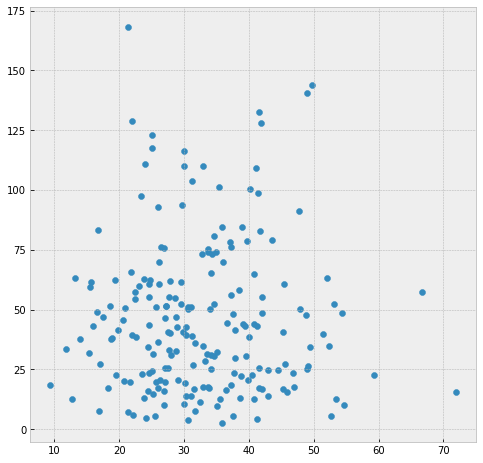

In [20]:
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(srw69_arr, column_area)

In [21]:
mucape_arr=np.asarray(mucape_arr)
mucape_1 = mucape_arr[np.isnan(column_area)==False]
column_area_1 = column_area[np.isnan(column_area)==False]

r_all = stats.spearmanr(mucape_1[np.isnan(mucape_1)==False], column_area_1[np.isnan(mucape_1)==False])
print(r_all)

SpearmanrResult(correlation=0.29314418853380464, pvalue=2.5242685961572182e-05)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Area')

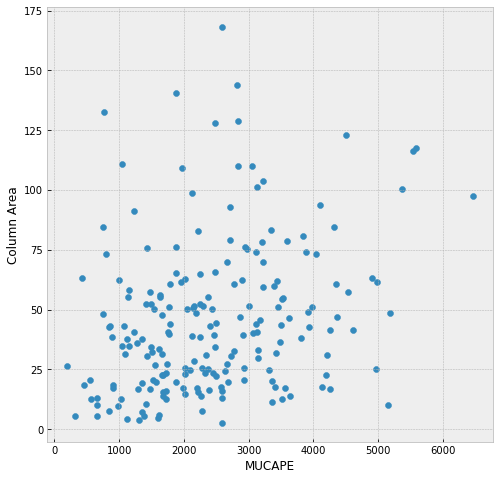

In [22]:
ind_v = 1
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(env_vars[ind_v], column_area)
plt.xlabel(var_names[ind_v])
plt.ylabel('Column Area')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Max Depth (km)')

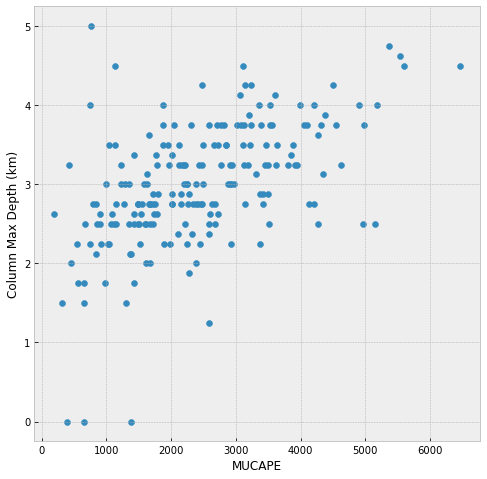

In [23]:
ind_v = 1
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(env_vars[ind_v], column_max_depth/4)
plt.xlabel(var_names[ind_v])
plt.ylabel('Column Max Depth (km)')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Mean Depth')

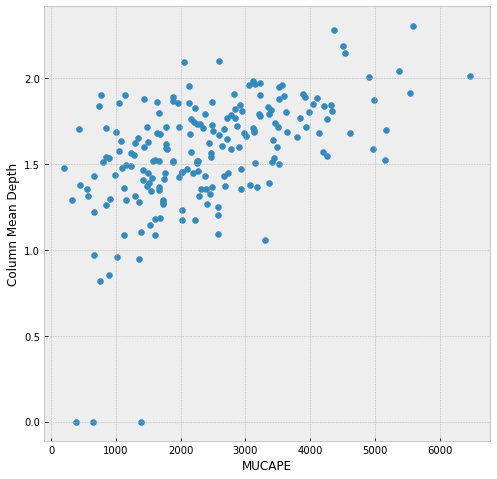

In [24]:
ind_v = 1
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(env_vars[ind_v], column_mean_depth/4)
plt.xlabel(var_names[ind_v])
plt.ylabel('Column Mean Depth')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Hail Area')

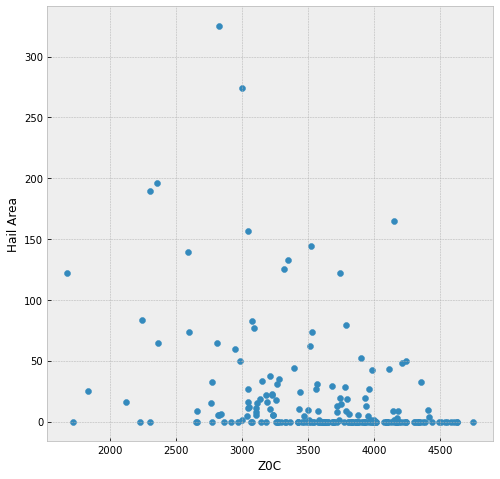

In [25]:
ind_v = 14
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(env_vars[ind_v], hail_area)
plt.xlabel(var_names[ind_v])
plt.ylabel('Hail Area')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Separation Angle')

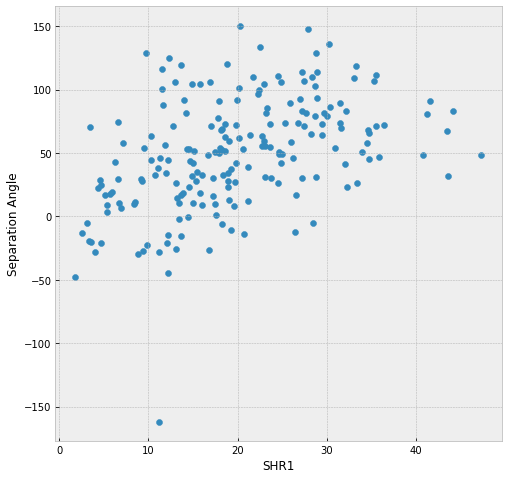

In [26]:
ind_v = 4
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(env_vars[ind_v], separation_angle)
plt.xlabel(var_names[ind_v])
plt.ylabel('Separation Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Max Depth (km)')

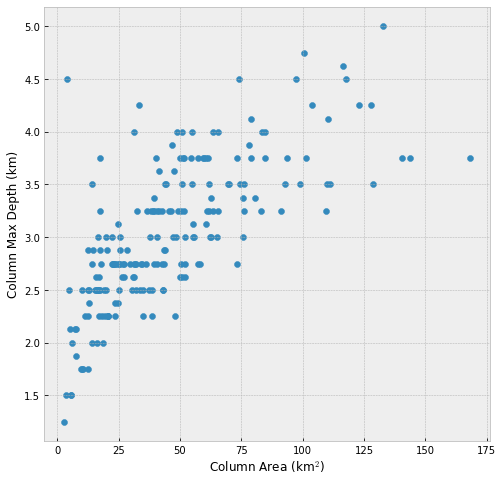

In [27]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_area, column_max_depth/4)
plt.xlabel('Column Area (km$^2$)')
plt.ylabel('Column Max Depth (km)')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Mean Depth')

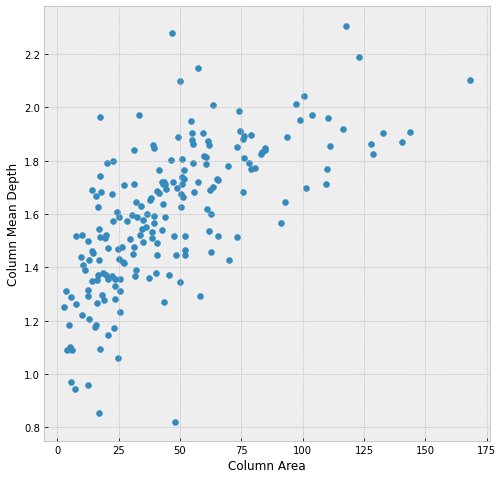

In [28]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_area, column_mean_depth/4)
plt.xlabel('Column Area')
plt.ylabel('Column Mean Depth')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Hail Area')

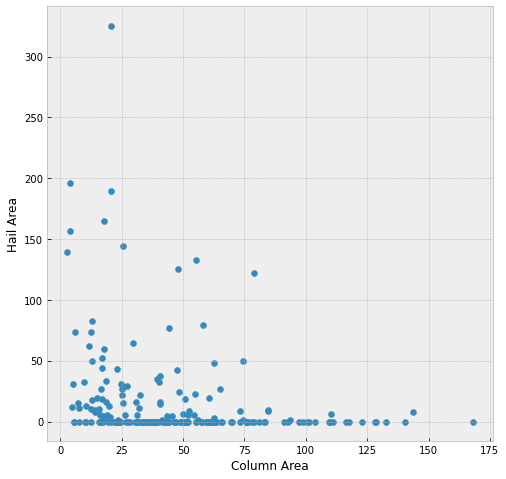

In [29]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_area, hail_area)
plt.xlabel('Column Area')
plt.ylabel('Hail Area')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Separation Angle')

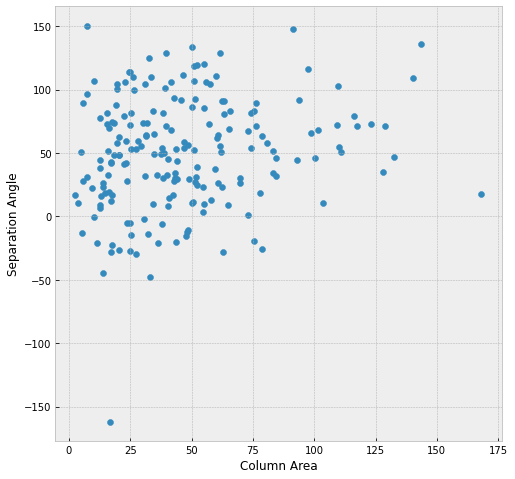

In [30]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_area, separation_angle)
plt.xlabel('Column Area')
plt.ylabel('Separation Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Column Mean Depth')

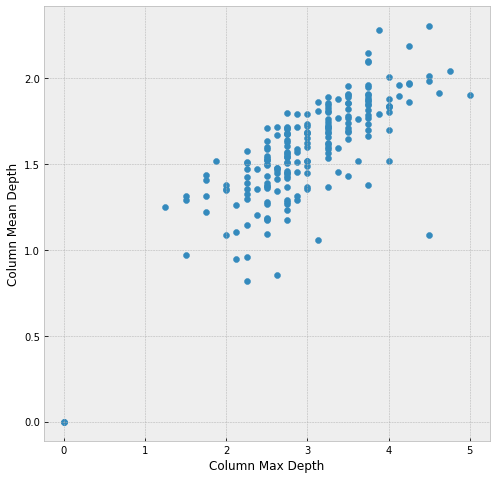

In [31]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_max_depth/4, column_mean_depth/4)
plt.xlabel('Column Max Depth')
plt.ylabel('Column Mean Depth')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Hail Area')

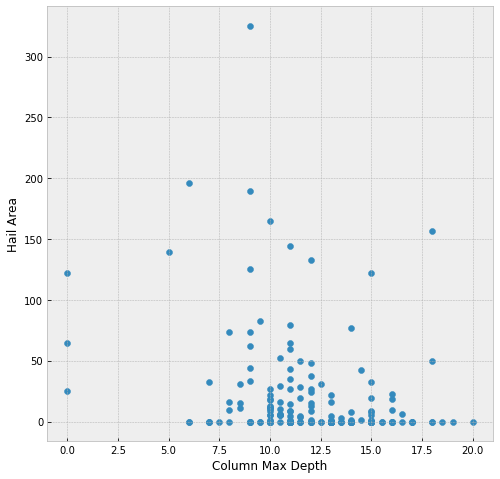

In [32]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_max_depth, hail_area)
plt.xlabel('Column Max Depth')
plt.ylabel('Hail Area')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Separation Angle')

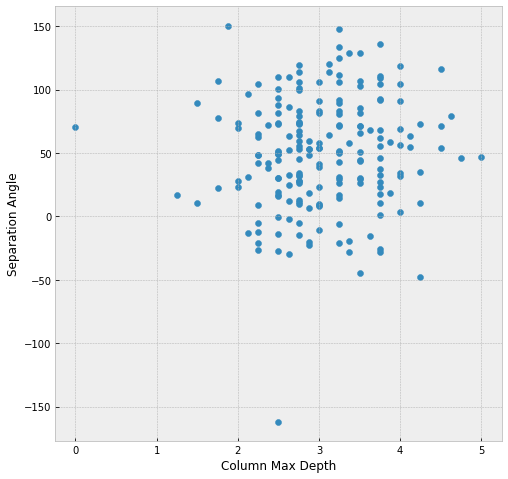

In [33]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_max_depth/4, separation_angle)
plt.xlabel('Column Max Depth')
plt.ylabel('Separation Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Hail Area')

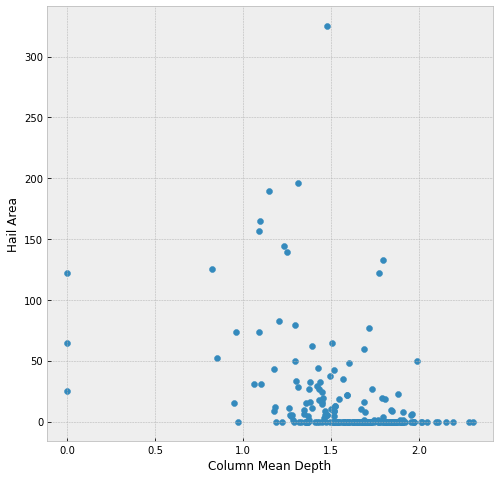

In [34]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_mean_depth/4, hail_area)
plt.xlabel('Column Mean Depth')
plt.ylabel('Hail Area')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Separation Angle')

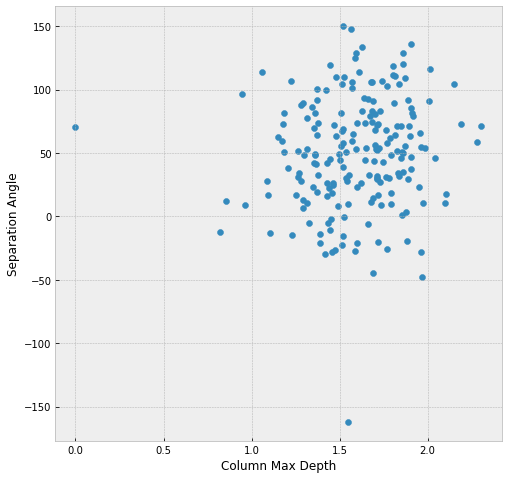

In [35]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(column_mean_depth/4, separation_angle)
plt.xlabel('Column Max Depth')
plt.ylabel('Separation Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Separation Angle')

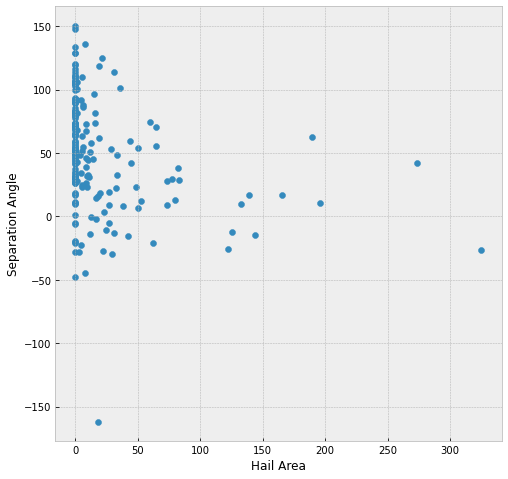

In [36]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(hail_area, separation_angle)
plt.xlabel('Hail Area')
plt.ylabel('Separation Angle')

In [37]:
#Get correlations for everything
variable = column_area
spork_var = column_max_depth/4

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column area / column max depth")

variable = column_area
spork_var = column_mean_depth/4

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column area / column mean depth")

variable = column_area
spork_var = hail_area

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column area / hail area")

variable = column_area
spork_var = separation_angle

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column area / separation angle")

variable = column_max_depth/4
spork_var = column_mean_depth/4

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column max depth / column mean depth")

variable = column_max_depth/4
spork_var = hail_area

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column max depth / hail area")

variable = column_max_depth/4
spork_var = separation_angle

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column max depth / separation angle")

variable = column_mean_depth/4
spork_var = hail_area

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column mean depth / hail area")

variable = column_mean_depth/4
spork_var = separation_angle

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "column mean depth / separation angle")

variable = hail_area
spork_var = separation_angle

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "hail area / separation angle")

#Add in correlations between arc area and everything else

variable = zdr_area
spork_var = column_area

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "zdr area / column area")

variable = zdr_area
spork_var = column_max_depth/4

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "zdr area / column max depth")

variable = zdr_area
spork_var = column_mean_depth/4

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "zdr area / column mean depth")

variable = zdr_area
spork_var = hail_area

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "zdr area / hail_area")

variable = zdr_area
spork_var = separation_angle

variable_1 = variable[np.isnan(spork_var)==False]
spork_var_1 = spork_var[np.isnan(spork_var)==False]

r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "zdr area / separation angle")

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SpearmanrResult(correlation=0.752434867189148, pvalue=9.34860303823209e-38) column area / column max depth
SpearmanrResult(correlation=0.7215765394134855, pvalue=1.88531548041138e-33) column area / column mean depth
SpearmanrResult(correlation=-0.38142642382597636, pvalue=2.511324570721315e-08) column area / hail area
SpearmanrResult(correlation=0.17594717506352264, pvalue=0.01387833509691475) column area / separation angle
SpearmanrResult(correlation=0.7841650702989107, pvalue=1.594113850729124e-43) column max depth / column mean depth
SpearmanrResult(correlation=-0.30585669693560624, pvalue=9.092992420241459e-06) column max depth / hail area
SpearmanrResult(correlation=0.08753105960402786, pvalue=0.2224878247800728) column max depth / separation angle
SpearmanrResult(correlation=-0.49154973679662733, pvalue=9.557040315921255e-14) column mean depth / hail area
SpearmanrResult(correlation=0.13637370606188592, pvalue=0.05665881127363779) column mean depth / separation angle
SpearmanrRes

In [38]:
#Get FFD angle dataset
ffdA = 190
ffdBB = 190
ffdCC = 190
ffdEE = 200
ffdFF = 230
ffdH = 150
ffdHH = 210
ffdI = 160
ffdJ = 170
ffdK = 120
ffdR = 200
ffdS = 160
ffdGG = 180
ffdE = 230

ffd1 = 140
ffd3 = 220
ffd6 = 190
ffd15 = 170
ffd22 = 130
ffd10 = 170
ffd13 = 150
ffd14 = 160
ffd16 = 180
ffd19 = 200
ffd21 = 150
ffd23 = 180
ffd24 = 190
ffd26 = 200
ffd27 = 160
ffd28 = 180
ffd29 = 180
ffd30 = 210
ffd32 = 160

ffdet1 = 180
ffdet3 = 165
ffdet6 = 125
ffdet8 = 170
ffdet9 = 205
ffdet11 = 190
ffdet13 = 180
ffdet14 = 220
ffdet16 = 145
ffdet20 = 190
ffdet23 = 195
ffdet26 = 170
ffdet33 = 110
ffdet34 = 150
ffdet35 = 180
ffdet36 = 140

ffden1 = 130
ffden2 = 165
ffden4 = 140
ffden7 = 180
ffden8 = 180
ffden9 = 150
ffden10 = 170
ffden11 = 125
ffden12 = 170

ffdcit1 = 225
ffdcit2 = 180
ffdcit3 = 190
ffdcit4 = 225
ffdcit5 = 155
ffdcit6 = 190
ffdcit8 = 200
ffdcit9 = 170
ffdcit10 = 190
ffdcit11 = 165
ffdcit12 = 190
ffdcit13 = 150
ffdcit14 = 180
ffdcit15 = 140
ffdcit17 = 190
ffdcit18 = 260
ffdcit19 = 190
ffdcit20 = 165
ffdcit22 = 190
ffdcit23 = 185
ffdcit24 = 130
ffdcit26 = 120
ffdcit27 = 130
ffdcit28 = 165
ffdcit29 = 170
ffdcit30 = 155
ffdcit31 = 145
ffdcit32 = 200
ffdcit34 = 170

ffdcin1 = 190
ffdcin2 = 180
ffdcin3 = 190
ffdcin4 = 180
ffdcin5 = 150
ffdcin6 = 210
ffdcin9 = 200
ffdcin10 = 160
ffdcin11 = 185
ffdcin12 = 140
ffdcin13 = 170
ffdcin14 = 195
ffdcin15 = 185
ffdcin16 = 150
ffdcin17 = 165
ffdcin18 = 165

ffdSN1 = 195
ffdSN2 = 160
ffdSN3 = 160 
ffdSN4 = 175
ffdSN5 = 170
ffdSN6 = 180
ffdSN7 = 145
ffdSN8 = 205
ffdSN9 = 200
ffdSN10 = 220
ffdSN11 = 180
ffdSN12 = 175
ffdSN13 = 135
ffdSN14 = 200
ffdSN15 = 235
ffdSN16 = 180
ffdSN17 = 180
ffdSN18 = 175
ffdSN19 = 225
ffdSN20 = 155
ffdSN21 = 150
ffdSN22 = 180
ffdSN23 = 185
ffdSN24 = 180
ffdSN25 = 190
ffdSN26 = 160
ffdSN27 = 160
ffdSN28 = 240
ffdSN29 = 180
ffdSN30 = 245
ffdSN31 = 125
ffdSN32 = 130
ffdSN33 = 210
ffdSN34 = 175
ffdSN35 = 165
ffdSN36 = 140
ffdSN37 = 170
ffdSN38 = 175
ffdSN39 = 180
ffdSN40 = 210
ffdSN42 = 195
ffdSN43 = 170
ffdSN44 = 180
ffdSN45 = 210
ffdSN46 = 225
ffdSN47 = 150
ffdSN48 = 230
ffdSN49 = 200
ffdSN50 = 190

ffdSN51 = 190
ffdSN52 = 220
ffdSN53 = 220
ffdSN54 = 215
ffdSN55 = 170

ffdSN56 = 195
ffdSN57 = 180
ffdSN58 = 155
ffdSN59 = 185
ffdSN60 = 190


ffdST1 = 115
ffdST2 = 150
ffdST3 = 150
ffdST4 = 175
ffdST5 = 200
ffdST6 = 115
ffdST7 = 160
ffdST8 = 120
ffdST9 = 180
ffdST10 = 155
ffdST11 = 160
ffdST12 = 180
ffdST13 = 225
ffdST14 = 210
ffdST15 = 180
ffdST16 = 155
ffdST17 = 180
ffdST18 = 185
ffdST19 = 170
ffdST20 = 135
ffdST21 = 185
ffdST24 = 160
ffdST27 = 180
ffdST28 = 165
ffdST30 = 245
ffdST31 = 155
ffdST33 = 180
ffdST34 = 140
ffdST35 = 140
ffdST37 = 185
ffdST38 = 210
ffdST39 = 155
ffdST40 = 205
ffdST41 = 140
ffdST42 = 150
ffdST43 = 160
ffdST44 = 200
ffdST45 = 185
ffdST47 = 195
ffdST48 = 190
ffdST50 = 185
ffdST51 = 170
ffdST52 = 205
ffdST53 = 240




C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# ffds = [ffdA, ffdBB, ffdCC, ffdEE, ffdFF, ffdH, ffdHH, ffdI, ffdJ, ffdK, ffdR, ffdS, ffdGG, ffdE, ffd1, ffd3, ffd6,
#         ffd15, ffd22, ffd10, ffd13, ffd14, ffd16, ffd19, ffd21, ffd23, ffd24, ffd26, ffd27, ffd28, ffd29, 
#         ffd30, ffd32, ffdet1, ffdet3, ffdet6, ffdet8, ffdet9, ffdet11, ffdet13, ffdet14, ffdet16, ffdet20,
#         ffdet23, ffdet26, ffdet33, ffdet34, ffdet35, ffdet36, ffden1, ffden2, ffden4, ffden7, ffden8, ffden9, 
#         ffden10, ffden11, ffden12, ffdcit1, ffdcit2, ffdcit3, ffdcit4, ffdcit5, ffdcit6, ffdcit8, ffdcit9, ffdcit10,
#         ffdcit11, ffdcit12, ffdcit13, ffdcit14, ffdcit15, ffdcit17, ffdcit18, ffdcit19, ffdcit20, ffdcit22, ffdcit23,
#         ffdcit24, ffdcit26, ffdcit27, ffdcit28, ffdcit29, ffdcit30, ffdcit31, ffdcit32, ffdcit34, ffdcin1, ffdcin2,
#         ffdcin3, ffdcin4, ffdcin5, ffdcin6, ffdcin9, ffdcin10, ffdcin11, ffdcin12, ffdcin13, ffdcin14, ffdcin15, ffdcin16,
#         ffdcin17, ffdcin18, ffdST1, ffdST2, ffdST3, ffdST4, ffdST5, ffdST6, ffdST7, ffdST8, ffdST9, ffdST10, ffdST11,
#         ffdST12, ffdST13, ffdST14, ffdST15, ffdST16, ffdST17, ffdST18, ffdST19, ffdST20, ffdST21, ffdST24, ffdST27, 
#         ffdST28, ffdST30, ffdST31, ffdST33, ffdST34, ffdST35, ffdST37, ffdST38, ffdST39, ffdST40, ffdST41, ffdST42,
#         ffdST43, ffdST44, ffdST45, ffdST47, ffdST48, ffdST50, ffdST51, ffdST52, ffdST53,ffdSN1,
#         ffdSN2,ffdSN3,ffdSN4,ffdSN5,ffdSN6,ffdSN7,ffdSN8,ffdSN9,ffdSN10,ffdSN11,ffdSN12,ffdSN13,ffdSN14,ffdSN15,ffdSN16,ffdSN17,
#         ffdSN18,ffdSN19,ffdSN20,ffdSN21,ffdSN22,ffdSN23,ffdSN24,ffdSN25,ffdSN26,ffdSN27,ffdSN28,ffdSN29,ffdSN30,ffdSN31,ffdSN32,ffdSN33,
#         ffdSN34,ffdSN35,ffdSN36,ffdSN37,ffdSN38,ffdSN39,ffdSN40,ffdSN42,ffdSN43,ffdSN44,ffdSN45,ffdSN46,ffdSN47,ffdSN48,ffdSN49,ffdSN50,
#         ffdSN51,ffdSN52,ffdSN53,ffdSN54,ffdSN55,ffdSN56,ffdSN57,ffdSN58,ffdSN59,ffdSN60]

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
ffds = np.asarray([ffdcit1, ffdcit2, ffdcit3, ffdcit4, ffdcit5, ffdcit6, ffdcit8, ffdcit9, ffdcit10,
        ffdcit11, ffdcit12, ffdcit13, ffdcit14, ffdcit15, ffdcit17, ffdcit18, ffdcit19, ffdcit20, ffdcit22, ffdcit23,
        ffdcit24, ffdcit26, ffdcit27, ffdcit28, ffdcit29, ffdcit30, ffdcit31, ffdcit32, ffdcit34, ffdcin1, ffdcin2,
        ffdcin3, ffdcin4, ffdcin5, ffdcin6, ffdcin9, ffdcin10, ffdcin11, ffdcin12, ffdcin13, ffdcin14, ffdcin15, ffdcin16,
        ffdcin17, ffdcin18,ffdet1, ffdet3, ffdet6, ffdet8, ffdet9, ffdet11, ffdet13, ffdet14, ffdet16, ffdet20,
        ffdet23, ffdet26, ffdet33, ffdet34, ffdet35, ffdet36, ffden1, ffden2, ffden4, ffden7, ffden8, ffden9, 
        ffden10, ffden11, ffden12,ffdA, ffdBB, ffdCC, ffdEE, ffdFF, ffdH, ffdHH, ffdI, ffdJ, ffdK, ffdR, ffdS, ffdGG, ffdE, ffd1, ffd3, ffd6,
        ffd15, ffd22, ffd10, ffd13, ffd14, ffd16, ffd19, ffd21, ffd23, ffd24, ffd26, ffd27, ffd28, ffd29, 
        ffd30, ffd32,ffdST1, ffdST2, ffdST3, ffdST4, ffdST5, ffdST6, ffdST7, ffdST8, ffdST9, ffdST10, ffdST11,
        ffdST12, ffdST13, ffdST14, ffdST15, ffdST16, ffdST17, ffdST18, ffdST19, ffdST20, ffdST21, ffdST24, ffdST27, 
        ffdST28, ffdST30, ffdST31, ffdST33, ffdST34, ffdST35, ffdST37, ffdST38, ffdST39, ffdST40, ffdST41, ffdST42,
        ffdST43, ffdST44, ffdST45, ffdST47, ffdST48, ffdST50, ffdST51, ffdST52, ffdST53,ffdSN1,
        ffdSN2,ffdSN3,ffdSN4,ffdSN5,ffdSN6,ffdSN7,ffdSN8,ffdSN9,ffdSN10,ffdSN11,ffdSN12,ffdSN13,ffdSN14,ffdSN15,ffdSN16,ffdSN17,
        ffdSN18,ffdSN19,ffdSN20,ffdSN21,ffdSN22,ffdSN23,ffdSN24,ffdSN25,ffdSN26,ffdSN27,ffdSN28,ffdSN29,ffdSN30,ffdSN31,ffdSN32,ffdSN33,
        ffdSN34,ffdSN35,ffdSN36,ffdSN37,ffdSN38,ffdSN39,ffdSN40,ffdSN42,ffdSN43,ffdSN44,ffdSN45,ffdSN46,ffdSN47,ffdSN48,ffdSN49,ffdSN50,
        ffdSN51,ffdSN52,ffdSN53,ffdSN54,ffdSN55,ffdSN56,ffdSN57,ffdSN58,ffdSN59,ffdSN60])

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
print(len(ffds))

206


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'FFD Angle')

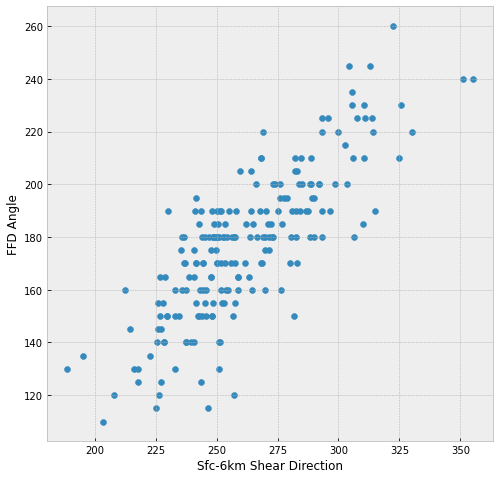

In [42]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(sfc_6km_shrdir, ffds)
plt.xlabel('Sfc-6km Shear Direction')
plt.ylabel('FFD Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'FFD Angle')

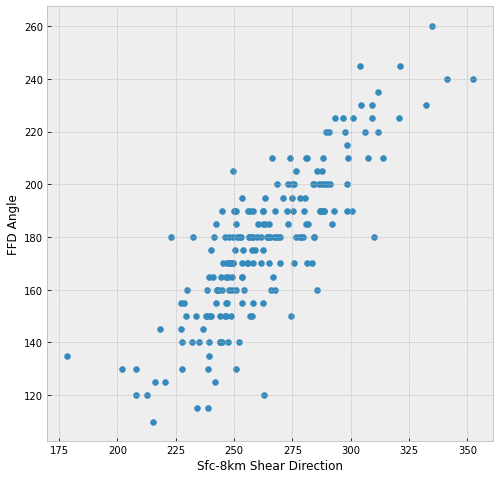

In [43]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(sfc_8km_shrdir, ffds)
plt.xlabel('Sfc-8km Shear Direction')
plt.ylabel('FFD Angle')

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'FFD Angle')

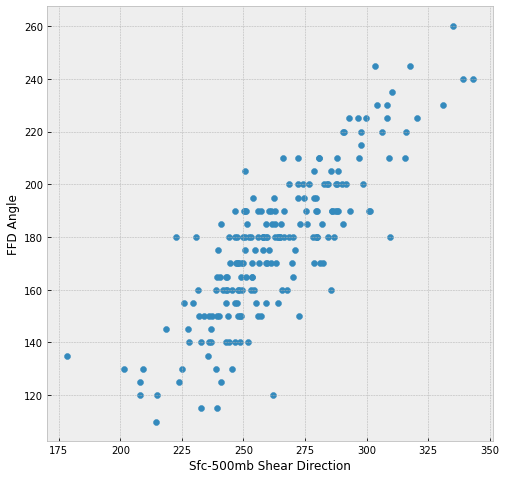

In [44]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(sfc_500_shrdir, ffds)
plt.xlabel('Sfc-500mb Shear Direction')
plt.ylabel('FFD Angle')

In [45]:
variable_1 = np.asarray(sfc_6km_shrdir)
spork_var_1 = ffds
r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "sfc-6 shear direction / ffd angle")

variable_1 = np.asarray(sfc_8km_shrdir)
spork_var_1 = ffds
r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "sfc-8 shear direction / ffd angle")

variable_1 = np.asarray(sfc_500_shrdir)
spork_var_1 = ffds
r_all = stats.spearmanr(variable_1[np.isnan(variable_1)==False], spork_var_1[np.isnan(variable_1)==False])
print(r_all, "sfc-500mb shear direction / ffd angle")

SpearmanrResult(correlation=0.781192266348806, pvalue=1.2923864278528179e-43) sfc-6 shear direction / ffd angle
SpearmanrResult(correlation=0.8147572902158905, pvalue=3.49615066407613e-50) sfc-8 shear direction / ffd angle
SpearmanrResult(correlation=0.8131856077667857, pvalue=7.590918952871139e-50) sfc-500mb shear direction / ffd angle


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
print(np.mean(sfc_500_shrdir)-np.mean(ffds))
print(np.mean(sfc_6km_shrdir)-np.mean(ffds))
print(np.mean(sfc_8km_shrdir)-np.mean(ffds))

86.08109033089295
84.75963421796774
86.06264504911724


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\spork2020\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'FFD Angle')

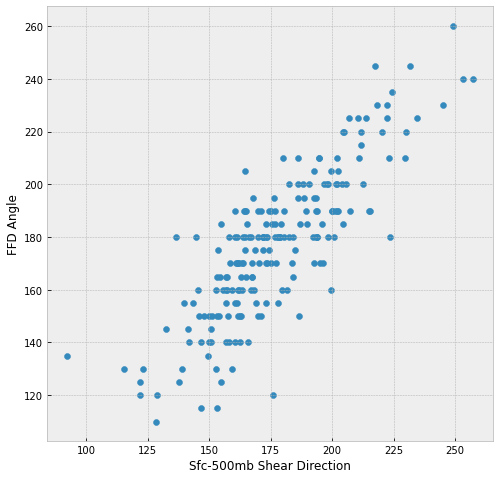

In [51]:
#Plot phase spaces for all variables compared to each other.
plt.style.use('bmh')
fig = plt.figure(1, (8, 8))
plt.scatter(np.asarray(sfc_500_shrdir)-86, ffds)
plt.xlabel('Sfc-500mb Shear Direction')
plt.ylabel('FFD Angle')